In [1]:
import numpy as np

In [2]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
b = np.array([1,2,3,4,5,6,7,8,9,10])

In [4]:
(a+b)[0]

2

In [5]:
import scipy.stats

In [6]:
scipy.stats.kendalltau(a, b)[0]

0.9999999999999999

In [14]:
import json
import pandas as pd

In [7]:
{'aspect': {'s'}}

{'aspect': {'s'}}

In [23]:
final_results = {
    'aspect': {'s':0},
    'prompt': {'s':0},
    'score': {
        'gt':[],
        'consistency': [1,2,3],
        'coherence': [1,2,3],
        'relevance': [1,2,3]
    },
    'kendall_tau': {'s':0.9}
}

In [25]:
final_results['score']['gt'] = [1,2,3,4,5,6,7,8,9,10]

In [28]:
import numpy as np

In [30]:
list(np.array([1,2,3]))

[1, 2, 3]

In [20]:
final_results.to_json('final_results.json')

AttributeError: 'dict' object has no attribute 'to_json'

In [24]:
with open('/Workspace/ky/SharedTask2023/results/summarization/OpenOrca-Platypus2-13B/train/ver2/2.json','w') as f:
    json.dump(final_results, f, ensure_ascii=False, indent=4)

# Eval4NLP - Summarzation task notebook


In [1]:
import sys
sys.path.append("./src")
from model_dict import *
from inference import *
import pandas as pd
import guidance
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.ver2.guidance_model import Summarization


In [2]:
summ_path = '/Workspace/jh/SharedTask2023/data/summarization/train_summarization.tsv'
summ_df = pd.read_csv(summ_path, delimiter="\t", quoting=csv.QUOTE_NONE)
SRC = summ_df['SRC']
HYP = summ_df['HYP']

In [3]:
# WizardLM-13B-V1.1-GPTQ
# Nous-Hermes-13b
# guanaco-65B-GPTQ
# OpenOrca-Platypus2-13B
# orca_mini_v3_7b
# Platypus2-70B-Instruct-GPTQ

model_name = 'orca_mini_v3_7b'
model_path = f'/Workspace/jh/SharedTask2023/models/{model_name}'

model, tokenizer, u_prompt, a_prompt = load_from_catalogue(model_name, model_path, device="cuda:1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
g_model = guidance.llms.Transformers(
            model, tokenizer=tokenizer, trust_remote_code=True,
)
guidance.llms.Transformers.cache.clear()

In [5]:
# we will use GPT-3 for most of the examples in this tutorial
guidance.llm = g_model

## 요약 생성 (핵심추출)

In [14]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [7]:
gt = SRC[14]
good = HYP[14]
soso = HYP[190]
bad = HYP[299]

idx = 259
gt2 = SRC[idx]
summary = HYP[idx]

In [11]:
guide_prompt = '''
{{prompt_placeholder}}

Generate one sentence of definition of {{aspect}} in terms of summarization.
And then, generate three lines of strategy to evaluate {{aspect}} of given summraization.
And then, generate conditions to evaluate {{aspect}} of given summraization to be {{score.good}} or {{score.soso}} or {{score.bad}}.
Make your answer in the form of:
Definition: definition of {{aspect}}

Strategy:
1. strategy 1
2. strategy 2
3. strategy 3

Condition:
{{score.good}}:
{{score.soso}}:
{{score.bad}}:

{{response_placeholder}}
{{gen 'answer' temperature=1 stop='###'}}
'''

In [9]:
penalty_prompt = '''
Your previous answer was not good enough.
So, your new answer must differ from the previous answer!!!
Previous answer:
'''

In [10]:
penalty_prompt = '''
{{prompt_placeholder}}
Generate one sentence of definition of {{aspect}} in terms of summarization.
And then, generate three lines of strategy to evaluate {{aspect}} of given summraization.
And then, generate conditions to evaluate {{aspect}} of given summraization to be {{score.good}} or {{score.soso}} or {{score.bad}}.
Make your answer in the form of:
Definition: definition of {{aspect}}

Strategy:
1. strategy 1
2. strategy 2
3. strategy 3

Condition:
{{score.good}}:
{{score.soso}}:
{{score.bad}}:

You need to keep in mind that your previous answer was not good enough.
So, carefully check your previous answer and make sure that you make a better answer than the previous one.
Previous answer:
{{previous_answer}}

{{response_placeholder}}
{{gen 'answer' temperature=1 stop='###'}}
'''

In [15]:
score = [{'good': 'Good', 'soso': 'Soso', 'bad': 'Bad'},
         {'good': 'Great', 'soso': 'Not bad', 'bad': 'Terrible'}]

guidance.llm.cache.clear()
program = guidance('''
    {{input_prompt}}
    ''')

executed_guide_program = program(
        input_prompt=guide_prompt,
        aspect='consistency',
        score=score[0],
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        caching=False)()

Stop program 
 
 ### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. 

 ### User: 

Generate one sentence of definition of consistency in terms of summarization.
And then, generate three lines of strategy to evaluate consistency of given summraization.
And then, generate conditions to evaluate consistency of given summraization to be Good or Soso or Bad .
Make your answer in the form of:
Definition: definition of consistency 

Strategy:
1. strategy 1
2. strategy 2
3. strategy 3

Condition:
 Good :
 Soso :
 Bad :

 ### Assistant: 
 Definition: Consistency refers to the uniformity of content, style, and tone across a summary, ensuring it accurately represents the original material and maintains coherence.

Strategy 1: Evaluate the summary's coherence by checking its structure, paragraphs, and transitions for continuous flow of information.
Strategy 2: Assess the summary's content and relevancy to the original material by identifying main points, key ideas, and inclusions/exclusions.
Strategy 3: Analyze the summary's language and clarity by assessing its grammar, sentence formation, and vocabulary choice.

Good: The summary is coherent, with a clear structure and smooth transitions, ensuring the content is relevant, and its language is easy to understand.
Soso: While there are certain aspects of coherence and content that are weak, the summary remains passable, albeit not as effective as it could be.
Bad: The summary is disjointed, missing key points, and difficult to understand due to syntax and vocabulary issues, hence it compromises on crucial aspects of consistency needed in an effective summary.

In [16]:
previous_answer = executed_guide_program['answer']

guidance.llm.cache.clear()
program = guidance('''
    {{input_prompt}}
    ''')

executed_penalty_program = program(
        input_prompt=penalty_prompt,
        aspect='consistency',
        score=score[0],
        previous_answer=previous_answer,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        caching=False)()

Stop program 
 
 ### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. 

 ### User: 
Generate one sentence of definition of consistency in terms of summarization.
And then, generate three lines of strategy to evaluate consistency of given summraization.
And then, generate conditions to evaluate consistency of given summraization to be Good or Soso or Bad .
Make your answer in the form of:
Definition: definition of consistency 

Strategy:
1. strategy 1
2. strategy 2
3. strategy 3

Condition:
 Good :
 Soso :
 Bad :

You need to keep in mind that your previous answer was not good enough.
So, carefully check your previous answer and make sure that you make a better answer than the previous one.
Previous answer:
 Definition: Consistency refers to the uniformity of content, style, and tone across a summary, ensuring it accurately represents the original material and maintains coherence.

Strategy 1: Evaluate the summary's coherence by checking its structure, paragraphs, and transitions for continuous flow of information.
Strategy 2: Assess the summary's content and relevancy to the original material by identifying main points, key ideas, and inclusions/exclusions.
Strategy 3: Analyze the summary's language and clarity by assessing its grammar, sentence formation, and vocabulary choice.

Good: The summary is coherent, with a clear structure and smooth transitions, ensuring the content is relevant, and its language is easy to understand.
Soso: While there are certain aspects of coherence and content that are weak, the summary remains passable, albeit not as effective as it could be.
Bad: The summary is disjointed, missing key points, and difficult to understand due to syntax and vocabulary issues, hence it compromises on crucial aspects of consistency needed in an effective summary. 

 ### Assistant: 
 Definition: Consistency refers to the consistent representation and organization of the original information in a summary to maintain coherence and avoid ambiguity.

Strategy 1: Evaluate the summary's coherence by analyzing its structure, transitions, and paragraphs for smooth flow of information.
Strategy 2: Assess the content and relevancy of the summary to the original material by identifying key ideas and including important information.
Strategy 3: Evaluate the summary's language and clarity by reviewing grammar, sentence structure, and vocabulary selection.

Good: A consistent summary demonstrates a well-structured and smooth narrative with clear content, relevant material, and effective usage of language.
Soso: A summary exhibits minor issues but generally maintains coherence and conveys the original information.
Bad: An inconsistent summary presents disjointed information, excluding crucial details, resulting in poor communication of the original text's intent.

In [17]:
score_prompt = '''
{{prompt_placeholder}}
Select the score of the following summary based on the given source text wheter it is {{score.good}} or {{score.soso}} or {{score.bad}}.

Source text:
{{source}}

Summary:
{{summary}}

{{guide}}

{{response_placeholder}}
{{select 'selection' logprobs='logprobs' options=options}}
'''

In [18]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

score = [{'good': 'Good', 'soso': 'Soso', 'bad': 'Bad'},
         {'good': 'Great', 'soso': 'Not bad', 'bad': 'Terrible'}]

score_option = list(score[0].values())
guide = executed_guide_program['answer']

program = guidance('''
    {{input_prompt}}
    ''')

executed_score_program = program(
        input_prompt=score_prompt,
        guide=guide,
        source=gt,
        summary=bad,
        score=score[0],
        options=score_option,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt)()

Stop program 
 
 ### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. 

 ### User: 
Select the score of the following summary based on the given source text wheter it is Good or Soso or Bad .

Source text:
 Referee Mark Clattenburg has been named to take charge of the Manchester derby on Sunday, despite having sent off three players from United and City this season. City captain Vincent Kompany was dismissed for two bookable offences during Belgium's narrow 1-0 defeat of Israel in their Euro 2016 qualifier on March 31, meaning he is now suspended for the match against Wales in June. And, although Clattenburg has been accused of favouring Louis van Gaal's side in the past, it's worth noting that the 40-year-old has only sent off two players season in the Premier League this season and both have been from United; Tyler Blackcett in the 5-3 defeat by Leicester and Luke Shaw in the 1-1 draw with West Ham. Mark Clattenburg will officiate the Manchester derby between United and City at Old Trafford The English referee sent off City and Belgium captain Vincent Kompany during the international break Leicester 5-3 Manchester United West Ham 1-1 Manchester United Manchester United 3-0 Tottenham Manchester City 3-1 West Ham Liverpool 2-1 Manchester City Chelsea 1-1 Manchester City Clattenburg has courted controversy during his career but is generally regarded as one of the Premier League's leading referees alongside Michael Oliver. The champion's shock 2-1 loss to Crystal Palace on Monday saw United move a point above their local rivals to add extra incentive for both sides ahead of the derby at Old Trafford, which could ultimately decide who finishes second behind expected winners Chelsea. While Manuel Pellegrini's side have struggled since the turn of the year, turning from title challengers to fourth place chases, United are coasting on confidence having won their last five consecutive league games. Clattenburg will be joined on Sunday by assistants Simon Beck and Jake Collin, while Jonathan Moss will serve as the fourth official. Clattenburg has shown only two red cards this season, both to United players including Luke Shaw (centre) 

Summary:
 United's win over Liverpool was their first league win since the 3-0 win over Leicester on March 31 City's win over West Ham was their first league win since the 3-0 win over Chelsea on March 31 Manchester City's win over West Ham was their first league win since the 3-0 win over Chelsea on March 31 Manuel Pellegrini's side are top of the Premier League table, four points clear of Chelsea, who have a game 

 Definition: Consistency refers to the uniformity and coherence of information within a summary, ensuring that it maintains the main ideas and details without inconsistencies or deviations.

Strategy:
1. Cohesive phrasing: Analyze how the summary maintains a smooth and continuity throughout, utilizing cohesive phrasing and transitions between ideas and key points.
2. Accurate representation: Assess how well the summary reflects and conveys the original content, ensuring that the information remains accurate and true to the source material.
3. Logical flow and sequence: Evaluate if the summary maintains a logical progression of ideas, emphasizing essential concepts and ideas in a logical and sequential manner.

Good: The summary is coherent, representative, and maintains a logical flow and sequence, presenting the important ideas from the original content without inconsistencies.
Soso: The summary is somewhat coherent, representational, and has some logical flow, but it still has inconsistencies or deviations, negatively affecting its overall quality.
Bad: The summary is incoherent, misrepresentative, and lacks any logical order, leaving out essential information or presenting it in incorrect ways, making it an unsatisfactory summary of the original content. 

 ### Assistant: 
 Good

In [2]:
a = (1, 0, 0)

In [6]:
type(a)

tuple

In [19]:
print(executed_score_program['logprobs'])
print(np.sum(np.exp(list(executed_score_program['logprobs'].values()))*np.array([5,3,1])))

{'Good': -0.04849068820476536, 'Soso': -3.8375532627105713, 'Bad': -3.6578657627105713}
4.8537573069361155


In [20]:
summ_df['Score'][14]

4.16666666665

In [17]:
np.exp(list(executed_score_program['logprobs'].values()))

array([0.3007877 , 0.68850993, 0.01070239])

In [ ]:
print(summ)

In [9]:
import numpy as np

In [16]:
results = []
for i in tqdm(range(len(SRC))):
    executed_one_sentence_program = program(
        gt=gt,
        good=good,
        soso=soso,
        bad=bad,
        gt2=SRC[i],
        summary=HYP[i],
        options=options,
        input_prompt=search_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        silent=True)()
    score = np.sum(np.exp(list(executed_one_sentence_program['logprobs'].values()))*[5,3,1])
    results.append(score)
    guidance.llm.cache.clear()
    torch.cuda.empty_cache()

  0%|          | 0/320 [00:00<?, ?it/s]/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 320/320 [03:33<00:00,  1.50it/s]


In [17]:
results

[4.907024792524207,
 4.450176132116139,
 3.7781264223280684,
 4.213616863360535,
 4.924155854716572,
 2.4283271908594997,
 4.497083013945636,
 4.5980336143529055,
 4.872665761338803,
 4.895884827110421,
 3.748180965895734,
 4.024156596839669,
 4.7139101037415365,
 4.617698322091041,
 4.996072289205071,
 4.250162203480365,
 4.653161224647974,
 4.840374328622286,
 4.451946202593994,
 4.9795449246526715,
 2.876754327731023,
 4.288711906834976,
 4.5635514299730335,
 4.281168826848784,
 4.4895703197845505,
 3.895319880968934,
 4.89155977370284,
 4.640075292398072,
 3.550419618837266,
 4.799765254578307,
 2.5387363872518818,
 4.771110292950202,
 4.929530376108391,
 4.937545987419396,
 4.764968515372157,
 4.261036924495152,
 4.972979794022119,
 4.946349767645565,
 4.416119855489214,
 4.507453869682208,
 4.497567931107122,
 4.5645412252882895,
 4.904845505996908,
 4.65753025164069,
 4.957726562955624,
 2.697081660918618,
 4.201579750719768,
 4.788623558060907,
 4.608905931961867,
 4.0073259693

In [18]:
import scipy.stats

In [19]:
scipy.stats.kendalltau(results, summ_df['Score'])[0]

0.40857946452100097

In [ ]:
final_results = {'prompt': {
    }, 'score': []}

In [13]:
final_results=    {
        'consistency': [],
        
        'prompt': {
            'guide': '',
            'score': '',
            },
        
        'scoring_option':{
            'good': '',
            'soso': '',
            'bad': '',
            },
        
        'score': {
            'gt': [],
            'aspect1': [],
            'aspect2': [],
            'aspect3': [],
            },
        
        'kendall_tau': {
        },
        
        'max_kendall_tau': []
    }

In [1]:
final_results['a']['max_kendall_tau2'] = 'kkk'

NameError: name 'final_results' is not defined

In [2]:
a = {}
a['1']['2'] = 3

KeyError: '1'

In [19]:
final_results

{'aspect': [],
 'prompt': {'guide': '', 'score': ''},
 'scoring_option': {'good': '', 'soso': '', 'bad': ''},
 'score': {'gt': [], 'aspect1': [], 'aspect2': [], 'aspect3': []},
 'kendall_tau': {},
 'max_kendall_tau': [],
 'max_kendall_tau2': 'kkk'}

## 요약 생성 (핵심추출)

In [18]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [19]:
program = guidance('''
    {{input_prompt}}
    ''')

In [20]:
gt = SRC[14]
good = HYP[14]
soso = HYP[190]
bad = HYP[299]

idx = 259
gt2 = SRC[idx]
summary = HYP[idx]
options = ['Good', 'Soso', 'Bad']

In [21]:
search_prompt = '''
{{prompt_placeholder}}

We'll show you the original document and examples of good and bad summaries. 
Think the differences between the two summaries in terms of key aspects of summarizations by thinking about the factors that must be considered when summarizing a document.

Generate concise and short aspects that played fundamental role to distinguish Good, Soso, Bad summaries.
The aspects must be concise and shorter than one sentences!

Source text: {{gt}}
Good summary: {{good}}
Soso summary: {{soso}}
Bad summary: {{bad}}

{{response_placeholder}}

Aspects: {{gen "aspects"}}


{{prompt_placeholder}}

And based on your answer, 
Select your assessment the quality of another source text and summary whether its is good or soso or bad.

Another source text: {{gt2}}
Another summary: {{summary}}

{{response_placeholder}}

Assessment: {{select 'assessment' options=options logprobs='logprobs'}}
'''

In [22]:
import numpy as np

In [23]:
results = []
for i in tqdm(range(len(SRC))):
    executed_one_sentence_program = program(
        gt=gt,
        good=good,
        soso=soso,
        bad=bad,
        gt2=SRC[i],
        summary=HYP[i],
        options=options,
        input_prompt=search_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        silent=True)()
    score = np.sum(np.exp(list(executed_one_sentence_program['logprobs'].values()))*[5,3,1])
    results.append(score)
    guidance.llm.cache.clear()
    torch.cuda.empty_cache()

  3%|▎         | 11/320 [01:36<44:58,  8.73s/it]2023-09-01 08:01:02,681 - 140513191260544 - base_events.py-base_events:1758 - ERROR: Task exception was never retrieved
future: <Task finished name='Task-32' coro=<Program.execute() done, defined at /opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program.py:430> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_93341/865866377.py", line 3, in <module>
    executed_one_sentence_program = program(
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program.py", line 295, in __call__
    loop.run_until_complete(new_program.execute())
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/nest_asyncio.py", line 84, in run_until_complete
    self._run_once()
  File "/opt/conda/envs/Ev

  3%|▎         | 11/320 [01:36<44:58,  8.73s/it]2023-09-01 08:01:02,681 - 140513191260544 - base_events.py-base_events:1758 - ERROR: Task exception was never retrieved
future: <Task finished name='Task-32' coro=<Program.execute() done, defined at /opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program.py:430> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_93341/865866377.py", line 3, in <module>
    executed_one_sentence_program = program(
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program.py", line 295, in __call__
    loop.run_until_complete(new_program.execute())
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/nest_asyncio.py", line 84, in run_until_complete
    self._run_once()
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/nest_asyncio.py", line 120, in _run_once
    handle._run()
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/asyncio/tasks.py", line 315, in __wakeup
    self.__step()
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/nest_asyncio.py", line 196, in step
    step_orig(task, exc)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program.py", line 450, in execute
    await self._executor.run(llm_session)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program_executor.py", line 109, in run
    await self.visit(self.parse_tree, VariableStack([self.program._variables], self))
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program_executor.py", line 559, in visit
    visited_children.append(await self.visit(child, variable_stack, inner_next_node, inner_next_next_node, inner_prev_node, node, parent_node))
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program_executor.py", line 266, in visit
    visited_children = [await self.visit(child, variable_stack, next_node, next_next_node, prev_node, node, parent_node) for child in node]
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program_executor.py", line 266, in <listcomp>
    visited_children = [await self.visit(child, variable_stack, next_node, next_next_node, prev_node, node, parent_node) for child in node]
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program_executor.py", line 379, in visit
    command_output = await command_function(*positional_args, **named_args)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/library/_gen.py", line 140, in gen
    gen_obj = await parser.llm_session(
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/llms/_transformers.py", line 335, in __call__
    generated_sequence = self.llm.model_obj.generate(**generate_args)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/utils.py", line 1596, in generate
    return self.greedy_search(
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/utils.py", line 2501, in greedy_search
    if unfinished_sequences.max() == 0:
KeyboardInterrupt
 82%|████████▏ | 263/320 [38:40<09:33, 10.06s/it]

In [24]:
results

[4.937632881135951,
 4.079576443776272,
 3.073567403132337,
 3.160100457015822,
 4.767442133254773,
 2.7464199990406795,
 3.782614695119638,
 3.5738510004477084,
 4.88135478890424,
 4.966107371873123,
 2.836710852216531,
 3.7287935838351274,
 4.556301171384967,
 3.241898254283276,
 4.998903958119582,
 4.632523904688117,
 4.422680457008519,
 4.703685375708526,
 3.1672860027928036,
 4.999276448897992,
 2.2929569941132177,
 3.2253509472558513,
 4.350821157642385,
 3.2473771341971953,
 4.737878298399773,
 2.878395305576154,
 4.907854310919663,
 4.430613830169656,
 3.2948698080943375,
 4.841456484939816,
 2.9071728991798684,
 4.817189272454624,
 4.937662037689566,
 4.9910835737978685,
 4.681252838875276,
 2.949671391206635,
 4.991881820862975,
 4.994911368193762,
 3.122136668825735,
 3.940166698533225,
 4.494177337739344,
 4.6887648059151505,
 4.968260145471964,
 4.059916964195988,
 4.99342460385395,
 3.023778030851655,
 3.481150735062412,
 4.579205068582307,
 4.046654430789913,
 3.10032478

In [25]:
import scipy.stats

In [26]:
scipy.stats.kendalltau(results, summ_df['Score'])[0]

0.3713923959034911

In [27]:
len(results)

320

## 요약 생성 (핵심추출)

In [39]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [40]:
program = guidance('''
    {{input_prompt}}
    ''')

In [41]:
summ_path = '/Workspace/jh/SharedTask2023/data/summarization/dev_summarization.tsv'
summ_df = pd.read_csv(summ_path, delimiter="\t", quoting=csv.QUOTE_NONE)
dev_SRC = summ_df['SRC']
dev_HYP = summ_df['HYP']

In [42]:
gt = SRC[14]
good = HYP[14]
soso = HYP[190]
bad = HYP[299]

idx = 259
gt2 = SRC[idx]
summary = HYP[idx]
options = ['Good', 'Soso', 'Bad']

In [43]:
search_prompt = '''
{{prompt_placeholder}}

We'll show you the original document and examples of good and bad summaries. 
Think the differences between the two summaries in terms of key aspects of summarizations by thinking about the factors that must be considered when summarizing a document.

Select your assessment the quality of another source text and summary whether its is good or soso or bad.

Source text: {{gt}}
Good summary: {{good}}
Soso summary: {{soso}}
Bad summary: {{bad}}

Another source text: {{gt2}}
Another summary: {{summary}}

{{response_placeholder}}

Assessment: {{select 'assessment' options=options logprobs='logprobs'}}
'''

In [44]:
import numpy as np

In [45]:
results = []
for i in tqdm(range(len(dev_SRC))):
    executed_one_sentence_program = program(
        gt=gt,
        good=good,
        soso=soso,
        bad=bad,
        gt2=dev_SRC[i],
        summary=dev_HYP[i],
        options=options,
        input_prompt=search_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        silent=True)()
    score = np.sum(np.exp(list(executed_one_sentence_program['logprobs'].values()))*[5,3,1])
    results.append(score)
    guidance.llm.cache.clear()
    torch.cuda.empty_cache()

  0%|          | 0/1280 [00:00<?, ?it/s]/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
  0%|          | 4/1280 [00:01<10:31,  2.02it/s]2023-09-01 09:24:29,307 - 140513191260544 - base_events.py-base_events:1758 - ERROR: Task exception was never retrieved
future: <Task finished name='Task-48' coro=<Program.execute() done, defined at /opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/guidance/_program.py:430> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_93341/865866377.py", line 3, in <module>
 

In [1]:
results

NameError: name 'results' is not defined

In [ ]:
import scipy.stats

In [ ]:
scipy.stats.kendalltau(results, summ_df['Score'])[0]

0.40857946452100097

In [186]:
options = ['Good', 'Soso', 'Bad']

guidance.llm.cache.clear()

executed_one_sentence_program = program(
        gt=gt,
        good=good,
        soso=soso,
        bad=bad,
        gt2=gt2,
        summary=summary,
        options=options,
        input_prompt=search_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt)()

Stop program 
 
 ### Instruction: 

We'll show you the original document and examples of good and bad summaries. 
Think the differences between the two summaries in terms of key aspects of summarizations by thinking about the factors that must be considered when summarizing a document.

Select your assessment the quality of another source text and summary whether its is good or soso or bad.

Source text: Referee Mark Clattenburg has been named to take charge of the Manchester derby on Sunday, despite having sent off three players from United and City this season. City captain Vincent Kompany was dismissed for two bookable offences during Belgium's narrow 1-0 defeat of Israel in their Euro 2016 qualifier on March 31, meaning he is now suspended for the match against Wales in June. And, although Clattenburg has been accused of favouring Louis van Gaal's side in the past, it's worth noting that the 40-year-old has only sent off two players season in the Premier League this season and both have been from United; Tyler Blackcett in the 5-3 defeat by Leicester and Luke Shaw in the 1-1 draw with West Ham. Mark Clattenburg will officiate the Manchester derby between United and City at Old Trafford The English referee sent off City and Belgium captain Vincent Kompany during the international break Leicester 5-3 Manchester United West Ham 1-1 Manchester United Manchester United 3-0 Tottenham Manchester City 3-1 West Ham Liverpool 2-1 Manchester City Chelsea 1-1 Manchester City Clattenburg has courted controversy during his career but is generally regarded as one of the Premier League's leading referees alongside Michael Oliver. The champion's shock 2-1 loss to Crystal Palace on Monday saw United move a point above their local rivals to add extra incentive for both sides ahead of the derby at Old Trafford, which could ultimately decide who finishes second behind expected winners Chelsea. While Manuel Pellegrini's side have struggled since the turn of the year, turning from title challengers to fourth place chases, United are coasting on confidence having won their last five consecutive league games. Clattenburg will be joined on Sunday by assistants Simon Beck and Jake Collin, while Jonathan Moss will serve as the fourth official. Clattenburg has shown only two red cards this season, both to United players including Luke Shaw (centre) 
Good summary: mark clattenburg will take charge of the manchester derby on sunday . the english referee sent off vincent kompany for belgium against israel . tyler blackcett and luke shaw have also been sent off for united . clattenburg will be joined by assistants simon beck and jake collin . jonathan moss will serve as the fourth official at old trafford . 
Soso summary: referee mark clattenburg has been named to take charge of the manchester derby on sunday . city captain vincent kompany was dismissed for two bookable offences during belgium 's narrow euro 2016 qualifier on march 31 . clattenburg has been accused of favouring louis van gaal 's side in the past . 
Bad summary: United's win over Liverpool was their first league win since the 3-0 win over Leicester on March 31 City's win over West Ham was their first league win since the 3-0 win over Chelsea on March 31 Manchester City's win over West Ham was their first league win since the 3-0 win over Chelsea on March 31 Manuel Pellegrini's side are top of the Premier League table, four points clear of Chelsea, who have a game 

Another source text: Paul Merson has restarted his row with Andros Townsend after the Tottenham midfielder was brought on with only seven minutes remaining in his team's 0-0 draw with Burnley on Sunday. 'Just been watching the game, did you miss the coach? #RubberDub #7minutes,' Merson put on Twitter. Merson initially angered Townsend for writing in his Sky Sports column that 'if Andros Townsend can get in (the England team) then it opens it up to anybody.' Paul Merson had another dig at Andros Townsend after his appearance for 

In [187]:
(executed_one_sentence_program['logprobs'])

{'Good': -1.7825992107391357,
 'Soso': -0.7669742107391357,
 'Bad': -1.0013492107391357}

In [188]:
import numpy as np
np.exp(executed_one_sentence_program['logprobs']['Good'])

0.16820039034289158

In [189]:
executed_one_sentence_program['logprobs'].values()

dict_values([-1.7825992107391357, -0.7669742107391357, -1.0013492107391357])

In [190]:
np.sum(np.exp(list(executed_one_sentence_program['logprobs'].values()))*[5,3,1])

2.6016338905471383

# EOS

In [13]:
score = {'good': 'Good', 'soso': 'Soso', 'bad': 'Bad'}

In [11]:
import json

In [14]:
with open('/Workspace/ky/SharedTask2023/prompt/ver2/score_options.json','w') as f:
    json.dump(score, f, ensure_ascii=False, indent=4)

In [7]:
ss = {}

In [8]:
ss['option'] = score

In [9]:
ss

{'option': {'good': 'Good', 'soso': 'Soso', 'bad': 'Bad'}}

In [18]:
search_prompt = '''
{{prompt_placeholder}}

We'll show you the original document and examples of good and bad summaries. 
Describe the differences between the two summaries in terms of key aspects of summarizations by thinking about the factors that must be considered when summarizing a document.
Answer abstractly, not by simply copying words from the summaries.
Generate your answer based on the key aspects of summarization, not based on the examples.

Source text: {{gt}}
Good summary: {{good}}
Bad summary: {{bad}}

{{response_placeholder}}

Differences: {{gen 'differences' temperature=1}}
'''

In [19]:
guidance.llm.cache.clear()

executed_one_sentence_program = program(
        gt=gt,
        good=good,
        bad=bad,
        input_prompt=search_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt)()

Stop program 
 
 ### Instruction: 

We'll show you the original document and examples of good and bad summaries. 
Describe the differences between the two summaries in terms of key aspects of summarizations by thinking about the factors that must be considered when summarizing a document.
Answer abstractly, not by simply copying words from the summaries.
Generate your answer based on the key aspects of summarization, not based on the examples.

Source text: Referee Mark Clattenburg has been named to take charge of the Manchester derby on Sunday, despite having sent off three players from United and City this season. City captain Vincent Kompany was dismissed for two bookable offences during Belgium's narrow 1-0 defeat of Israel in their Euro 2016 qualifier on March 31, meaning he is now suspended for the match against Wales in June. And, although Clattenburg has been accused of favouring Louis van Gaal's side in the past, it's worth noting that the 40-year-old has only sent off two players season in the Premier League this season and both have been from United; Tyler Blackcett in the 5-3 defeat by Leicester and Luke Shaw in the 1-1 draw with West Ham. Mark Clattenburg will officiate the Manchester derby between United and City at Old Trafford The English referee sent off City and Belgium captain Vincent Kompany during the international break Leicester 5-3 Manchester United West Ham 1-1 Manchester United Manchester United 3-0 Tottenham Manchester City 3-1 West Ham Liverpool 2-1 Manchester City Chelsea 1-1 Manchester City Clattenburg has courted controversy during his career but is generally regarded as one of the Premier League's leading referees alongside Michael Oliver. The champion's shock 2-1 loss to Crystal Palace on Monday saw United move a point above their local rivals to add extra incentive for both sides ahead of the derby at Old Trafford, which could ultimately decide who finishes second behind expected winners Chelsea. While Manuel Pellegrini's side have struggled since the turn of the year, turning from title challengers to fourth place chases, United are coasting on confidence having won their last five consecutive league games. Clattenburg will be joined on Sunday by assistants Simon Beck and Jake Collin, while Jonathan Moss will serve as the fourth official. Clattenburg has shown only two red cards this season, both to United players including Luke Shaw (centre) 
Good summary: mark clattenburg will take charge of the manchester derby on sunday . the english referee sent off vincent kompany for belgium against israel . tyler blackcett and luke shaw have also been sent off for united . clattenburg will be joined by assistants simon beck and jake collin . jonathan moss will serve as the fourth official at old trafford . 
Bad summary: United's win over Liverpool was their first league win since the 3-0 win over Leicester on March 31 City's win over West Ham was their first league win since the 3-0 win over Chelsea on March 31 Manchester City's win over West Ham was their first league win since the 3-0 win over Chelsea on March 31 Manuel Pellegrini's side are top of the Premier League table, four points clear of Chelsea, who have a game 

 ### Response: 

Differences: 
1) The good summary provides a concise overview of the key aspects about Mark Clattenburg officiating the Manchester derby, including his decision to send off Vincent Kompany and that he has only booked two other players.
2) The bad summary contains misinterpretations and irrelevant information not found in the source text. Specifically, it incorrectly states that Liverpool won their first league victory over United since 3-0 win over Leicester, which is an incorrect reference. Also, it mentions the wrong win figures for West Ham and Manchester City that are contradictory statements with respect to the source text.
3) The good summary efficiently communicates the main points while maintaining clarity, whereas the bad summary consists of numerous errors

## 앞서 생성한 요약문들의 core를 다시 한 번 추출하고
## 답변한 core를 근거삼아 gt 요약문이 해당 내용들을 포함하고 있는지 여부 확인

In [427]:
aspects = executed_one_sentence_program.variables()['summarization'].split('\n')
aspects = list(filter(None, aspects))
aspects

['1. Missouri mom Becky Schoenig experiences car theft and receives it back with custom modifications.',
 '2. Schoenig thanks the car thieves for pimping her vehicle and creates the Sexton on Wheels smoothie at her restaurant in honor of the man who found the car.']

In [171]:
# prototype

guidance.llm.cache.clear()
torch.cuda.empty_cache()

concise_prompt = '''
{{prompt_placeholder}}

Generate a concise version of Source text as breif as possible.
You should focus on "who" did " "what" and delete unnecessary words.
Delete something that too detailed or redundant.


Source text: {{gt}}

{{response_placeholder}}
Concise version of given sentence: {{gen 'concise_text' temperature=1}}
'''

guidance.llm.cache.clear()

executed_one_sentence_program = program(
        gt=aspects[1],
        # hyp=HYP[idx],
        input_prompt=concise_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt)()

Stop program 
 
 ### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. 

 ### User: 

Generate a concise version of Source text as breif as possible.
You should focus on "who" did " "what" and delete unnecessary words.
Delete something that too detailed or redundant.


Source text: The squad includes talented young players from various Premier League clubs such as Dasilva, Willock, Mavididi, and Ugbo. A notable inclusion is Arsenal's Christopher Willock. 

 ### Assistant: 
Concise version of given sentence: The squad features young talent from Premier League clubs, including Christopher Willock from Arsenal.

In [403]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

# score_prompt = '''
# {{prompt_placeholder}}
# You will be given a summary and a aspect.
# Read the summary and the aspect carefully.

# Summary: {{summary}}
# Aspect: {{aspects}}

# {{response_placeholder}}

# Do you REALLY think the summary contains the aspect?
# Please answer my question carefully.

# Answer: {{gen 'answer' temperature=1}}

# Based on your answer "{{answer}}", score the summary from 0 to 5.

# Score: {{gen 'score' pattern='[0-5]' temperature=1}}

# '''


score_prompt = '''
{{prompt_placeholder}}
You will be given a summary and a aspect.
Read the summary and the aspect carefully.

Summary: {{summary}}
Aspect: {{aspects}}

{{response_placeholder}}
Explain a core idea of given aspect shortly.
Explain: {{gen 'explain' temperature=1}}

Do you REALLY think the summary contains the context of this sentence? "{{explain}}" answer my question shortly.
You should carefully inspect the summary word by word!
Answer: {{gen 'answer' temperature=1}}

Based on your answer "{{answer}}", score the summary from 1 to 5. 
Score 1 means that the summary doesn't contain the core of the aspect.
And score of 5 means that the summary perfectly contains the core of the aspect.

Score: {{gen 'score' pattern='[1-5]'}}

'''

# pattern='(100|[1-9]?[0-9])'
# Score very carefully and critically whether the summary really captures the meaning of the aspect 


In [428]:
# prototype

guidance.llm.cache.clear()
torch.cuda.empty_cache()

score_prompt = '''
{{prompt_placeholder}}
You will be given a summary and a aspect.
Read the summary and the aspect carefully.

Summary: {{summary}}
Aspect: {{aspects}}

{{response_placeholder}}

Generate a more concise version of Source text as breif as possible in one sentence.
You should focus on "who" did " "what" and delete unnecessary words.
Delete something that too detailed or redundant.
Refine the language used in the sentence with more general words.
Concise version must not be longer than original text.


Concise version of Aspect: {{gen 'explain' temperature=1}}


Do you think the summary has any similar context of "{{explain}},{{aspects}}", even roughly?
Generate your Answer carefully.

Answer: {{gen "answer" temperature=1}}


Based on your answer "{{answer}}", score the summary from 1 to 5. 
If the summary doesn't have similar meaning, score 1.
If the summary has similar meaning, score 5.

Score: {{gen 'score' pattern='[1-5]' temperature=0}}

'''


In [429]:
# options = ['poor', 'fair', 'good', 'great', 'excellent']

program = guidance('''
    {{input_prompt}}
    ''')

In [430]:
 results = {'summary':[],
            'aspect':[],
            'explain':[],
            'answer':[],
            'score':[]}
 
 for aspect in aspects:
        guidance.llm.cache.clear()
        torch.cuda.empty_cache()

        executed_program = program(
                summary=HYP[idx],
                aspects=aspect,
                input_prompt=score_prompt,
                prompt_placeholder=u_prompt,
                response_placeholder=a_prompt,
                silent=False)()
        
        var = executed_program.variables()
        results['summary'].append(var['summary'])
        results['aspect'].append(var['aspects'])
        results['explain'].append(var['explain'])
        results['answer'].append(var['answer'])
        results['score'].append(int(var['score']))

Stop program 
 
 ### System: You are an AI assistant that follows instruction extremely well. Help as much as you can. 

 ### User: 
You will be given a summary and a aspect.
Read the summary and the aspect carefully.

Summary: becky schoenig of st. louis , missouri was shocked when she realized her brand new 2015 ford fusion had been stolen from her driveway on monday night , just a little over a month after she took the car home . schoenig was shocked to learn that police had found her car after receiving a tip from a man who recognized the vehicle as schoenig 's and would be returning it to her . the brand new 2015 ford fusion had been stolen from her driveway monday . 
Aspect: 2. Schoenig thanks the car thieves for pimping her vehicle and creates the Sexton on Wheels smoothie at her restaurant in honor of the man who found the car. 

 ### Assistant: 

Generate a more concise version of Source text as breif as possible in one sentence.
You should focus on "who" did " "what" and delete unnecessary words.
Delete something that too detailed or redundant.
Refine the language used in the sentence with more general words.
Concise version must not be longer than original text.


Concise version of Aspect: Becky Schoenig thanks the car thieves for customizing her stolen vehicle and creates a smoothie at her restaurant for the man who found it. 


Do you think the summary has any similar context of " Becky Schoenig thanks the car thieves for customizing her stolen vehicle and creates a smoothie at her restaurant for the man who found it. , 2. Schoenig thanks the car thieves for pimping her vehicle and creates the Sexton on Wheels smoothie at her restaurant in honor of the man who found the car. ", even roughly?
Generate your Answer carefully.

Answer: Yes, there is a rough similarity in context between the summary and the aspect regarding Becky Schoenig thanking the car thieves for customizing her stolen vehicle, creating the Sexton on Wheels smoothie at her restaurant in honor of the man who found it. 


Based on your answer " Yes, there is a rough similarity in context between the summary and the aspect regarding Becky Schoenig thanking the car thieves for customizing her stolen vehicle, creating the Sexton on Wheels smoothie at her restaurant in honor of the man who found it. ", score the summary from 1 to 5. 
If the summary doesn't have similar meaning, score 1.
If the summary has similar meaning, score 5.

Score: 4

In [431]:
summ_df['Score'][idx]

4.25

In [432]:
results

{'summary': ["becky schoenig of st. louis , missouri was shocked when she realized her brand new 2015 ford fusion had been stolen from her driveway on monday night , just a little over a month after she took the car home . schoenig was shocked to learn that police had found her car after receiving a tip from a man who recognized the vehicle as schoenig 's and would be returning it to her . the brand new 2015 ford fusion had been stolen from her driveway monday .",
  "becky schoenig of st. louis , missouri was shocked when she realized her brand new 2015 ford fusion had been stolen from her driveway on monday night , just a little over a month after she took the car home . schoenig was shocked to learn that police had found her car after receiving a tip from a man who recognized the vehicle as schoenig 's and would be returning it to her . the brand new 2015 ford fusion had been stolen from her driveway monday ."],
 'aspect': ['1. Missouri mom Becky Schoenig experiences car theft and re

In [433]:
np.mean(results['score'])

4.5

In [225]:
results['mean_score'] = np.mean(results['score'])

In [22]:
results.variables()

AttributeError: 'dict' object has no attribute 'variables'

In [6]:
import json
with open('./testtest.json','w') as f:
  json.dump(results, f, ensure_ascii=False, indent=4)

In [50]:
results

{'summary': ["thierry henry has criticised arsenal 's recent dealings in the transfer window and has urged his former side to purchase four top players in the summer . sky sports pundit thierry henry questioned whether arsenal can win the title with olivier giroud in attack . sunderland -lrb- home -rrb- may 20 .",
  "thierry henry has criticised arsenal 's recent dealings in the transfer window and has urged his former side to purchase four top players in the summer . sky sports pundit thierry henry questioned whether arsenal can win the title with olivier giroud in attack . sunderland -lrb- home -rrb- may 20 .",
  "thierry henry has criticised arsenal 's recent dealings in the transfer window and has urged his former side to purchase four top players in the summer . sky sports pundit thierry henry questioned whether arsenal can win the title with olivier giroud in attack . sunderland -lrb- home -rrb- may 20 .",
  "thierry henry has criticised arsenal 's recent dealings in the transfer

In [46]:
final_results = []

In [29]:
final_results.append(results)

In [30]:
final_results

[{'summary': ["thierry henry has criticised arsenal 's recent dealings in the transfer window and has urged his former side to purchase four top players in the summer . sky sports pundit thierry henry questioned whether arsenal can win the title with olivier giroud in attack . sunderland -lrb- home -rrb- may 20 .",
   "thierry henry has criticised arsenal 's recent dealings in the transfer window and has urged his former side to purchase four top players in the summer . sky sports pundit thierry henry questioned whether arsenal can win the title with olivier giroud in attack . sunderland -lrb- home -rrb- may 20 .",
   "thierry henry has criticised arsenal 's recent dealings in the transfer window and has urged his former side to purchase four top players in the summer . sky sports pundit thierry henry questioned whether arsenal can win the title with olivier giroud in attack . sunderland -lrb- home -rrb- may 20 .",
   "thierry henry has criticised arsenal 's recent dealings in the tran

In [31]:
pd.DataFrame(final_results)

summary  \
0  [thierry henry has criticised arsenal 's recen...   
1  [thierry henry has criticised arsenal 's recen...   

                                              aspect  \
0  [1. Thierry Henry urges Arsenal to sign four t...   
1  [1. Thierry Henry urges Arsenal to sign four t...   

                                             explain  \
0  [This aspect of the information states that Ar...   
1  [This aspect of the information states that Ar...   

                                              answer          score  
0  [D: I don't think the summary contains the cor...  [0, 10, 6, 0]  
1  [D: I don't think the summary contains the cor...  [0, 10, 6, 0]

In [51]:
pd.DataFrame(final_results).to_csv("./test.csv", index=False)

IsADirectoryError: [Errno 21] Is a directory: './'

In [225]:
summ_df['Score'].sort_values()

299    1.333333
259    1.750000
285    1.833333
205    1.916667
228    2.166667
         ...   
66     5.000000
260    5.000000
129    5.000000
256    5.000000
188    5.000000
Name: Score, Length: 320, dtype: float64

In [ ]:
executed_program.variables

In [ ]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [ ]:
options = ['poor', 'fair', 'good', 'great', 'excellent']

In [ ]:
eval_v2_confidence_prompt = '''
{{prompt_placeholder}}
You will be given one summary written for a source document.
Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Select a score for coherence among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Select a score for consistency among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Select a score for relevance among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

poor, fair, good, great, excellent, in that order, means a higher score.
——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{select 'coherence' logprobs='coherence_probs' options=options}}
Consistency Score: {{select 'consistency' logprobs='consistency_probs' options=options}}
Relevance Score: {{select 'relevance' logprobs='relevance_probs' options=options}}
'''

In [ ]:
results_v2_confidence = {
           'coherence':[],
           'consistency':[],
           'relevance':[],
           'summ':[],
           'mean':[]
           }

SRC = summ_df['SRC']
HYP = summ_df['HYP']
score_of_rank = np.array(list(rank.values()))

for idx in tqdm(range(len(SRC))):
    
    guidance.llm.cache.clear()

    eval_program = guidance('''
    {{eval_v2_prompt}}
    ''')

    executed_program = eval_program(
        gt=SRC[idx],
        hyp=HYP[idx],
        eval_v2_prompt=eval_v2_confidence_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        options=options,
        silent=True)()
    
    coherence = np.sum(np.exp(list(executed_program['coherence_probs'].values()))*score_of_rank)
    consistency = np.sum(np.exp(list(executed_program['consistency_probs'].values()))*score_of_rank)
    relevance = np.sum(np.exp(list(executed_program['relevance_probs'].values()))*score_of_rank)
    summ = coherence + consistency + relevance
    mean = summ/3

    results_v2_confidence['coherence'].append(coherence)
    results_v2_confidence['consistency'].append(consistency)
    results_v2_confidence['relevance'].append(relevance)
    results_v2_confidence['summ'].append(summ)
    results_v2_confidence['mean'].append(mean)
    

  0%|          | 0/320 [00:00<?, ?it/s]/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 320/320 [03:46<00:00,  1.42it/s]


In [173]:
HYP[idx]

"within ten minutes of tomorrow night 's episode , fans will see aidan turner 's dashing ross poldark gaze lovingly at his new baby daughter . last week she was barely showing -- but demelza poldark is now the proud mother to the show 's latest addition . last week she was barely showing -- but demelza poldark is now the proud mother to the show 's latest addition ."

In [114]:
summ_df['Score'][idx]

3.91666666665

In [51]:
executed_program.variables()

{'llm': <guidance.llms._transformers.Transformers at 0x7fc035ea5420>,
 'logging': False,
 'gt': '"(CNN)A fiery sunset greeted people in Washington Sunday. The deep reddish color caught Seattle native Tim Durkan\'s eye. He photographed a handful of aerial shots of the sunset warming the city\'s skyline and shared them on CNN iReport. The stunning sunsets were the result of raging wildfires in parts of Siberia. ""The dramatic sunsets began showing up over the weekend and had Seattle locals wondering where the amber-colored haze was originating from,"" Durken said. The fires were started in southeastern Siberia, by farmers burning grass in their fields. But on April 14, it is believed that the flames quickly grew out of control because of strong winds and spread throughout the region, according to CNN affiliate KOMO-TV. As a result, the fires have destroyed dozens of villages in the region. Rescue crews were able to put out the flames. However, the lingering smoke from the widespread fire

In [37]:
keyword_prompt = '''
{{prompt_placeholder}}

First, generate just one keyword that should be considered when summarizing a document.
{{response_placeholder}}
Keywords: {{gen 'keywords' temperature=1 n=5}}

Then, you will be given one summary written for a source document.
Your task is to rate the summary based on the keywords.
Please make sure you read and understand these keywords carefully. Please keep this document open while reviewing, and refer to it as needed.

Source text: {{gt}}
Summary: {{hyp}}

{{#each keywords}}
Keyword: {{this}}
Do you think the summary adequately captures the value of this keyword?
Explain your thought first.

{{response_placeholder}}
{{gen 'thought' list_append=True}}

And score the summary based on your answer on a scale of 0 to 100, where 1 is the lowest and 100 is the highest.
{{response_placeholder}}
{{gen 'score' pattern='(100|[1-9]?[0-9])' list_append=True}}
{{/each}}
'''

In [38]:
keyword_program = guidance('''
    {{keyword_prompt}}
    ''')

In [39]:
guidance.llm.cache.clear()

executed_program = keyword_program(
        gt=SRC[2],
        hyp=HYP[2],
        keyword_prompt=keyword_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt)()

Stop program 
 
 ### Instruction: 

First, generate just one keyword that should be considered when summarizing a document.
 ### Response: 
Keywords: <div style='background: rgba(255, 255, 255, 0.0); border-radius: 4px 0px 0px 4px; border: 1px solid rgba(0, 165, 0, 0.25); border-right: 0px; padding-left: 3px; padding-right: 3px; user-select: none; color: rgba(0, 165, 0, 0.25); display: inline; font-weight: normal; cursor: pointer' onClick='function cycle_201ad0df35af45e5b80b4d129dd72c29(button_el) { var i = 0; while (i < 50) { var el = document.getElementById("201ad0df35af45e5b80b4d129dd72c29_" + i); if (el.style.display == "inline") { el.style.display = "none"; var next_el = document.getElementById("201ad0df35af45e5b80b4d129dd72c29_" + (i+1)); if (!next_el) { next_el = document.getElementById("201ad0df35af45e5b80b4d129dd72c29_0"); } if (next_el) { next_el.style.display = "inline"; } break; } i += 1; } button_el.innerHTML = (((i+1) % 5) + 1) + "/" + 5;}cycle_201ad0df35af45e5b80b4d129dd72c29(this);'>1/5 importance, technology, innovation, society relevance, coherence, conciseness, important points, main ideas. Summarization, Text Analysis, NLP, Extraction, Abstraction. summarize, document, keyword, important, content, information, main, theme, ideas, topic, sentence, paragraph, critical, thinking, skills Information Extraction, Text Summarization, Lexical Chains. 

Then, you will be given one summary written for a source document.
Your task is to rate the summary based on the keywords.
Please make sure you read and understand these keywords carefully. Please keep this document open while reviewing, and refer to it as needed.

Source text: "(CNN)A fiery sunset greeted people in Washington Sunday. The deep reddish color caught Seattle native Tim Durkan's eye. He photographed a handful of aerial shots of the sunset warming the city's skyline and shared them on CNN iReport. The stunning sunsets were the result of raging wildfires in parts of Siberia. ""The dramatic sunsets began showing up over the weekend and had Seattle locals wondering where the amber-colored haze was originating from,"" Durken said. The fires were started in southeastern Siberia, by farmers burning grass in their fields. But on April 14, it is believed that the flames quickly grew out of control because of strong winds and spread throughout the region, according to CNN affiliate KOMO-TV. As a result, the fires have destroyed dozens of villages in the region. Rescue crews were able to put out the flames. However, the lingering smoke from the widespread fires were picked up by atmospheric winds. The winds carried the smoke from Siberia across the Pacific Ocean and brought it to the Pacific Northwest. Parts of Oregon, Washington and British Columbia are seeing the results of the smoke, wind and solar light combination. The reason people are seeing an intense red sunset is a result of smoke particles filtering out the shorter wavelength colors from the sunlight like greens, blues, yellows and purples, KOMO-TV said. That means colors like red and orange are able to penetrate the air unfiltered. The colors are especially intense during sunrises and sunsets because there is more atmosphere for the light to travel through to get to a person's eye. As the smoke starts to dissipate, air quality will get better and these fiery sunsets will lose their reddish hue." 
Summary: tim durkan photographed aerial shots of the sunset warming the city 's skyline and shared them on cnn ireport . the fires were started in southeastern siberia , by farmers burning grass in their fields . the flames quickly grew out of control because of strong winds and spread throughout the region . 

<span style='opacity: 1.0; display: inline; background-color: rgba(165, 165, 165, 0.1);' title='{{#each keywords}}
Keyword: {{this}}
Do you think the summary adequately captures the value of this keyword?
Explain your thought first.

{{response_placeholder}}
{{gen 'thought' list_append=True}}

And score 

In [14]:
results_v1 = {
           'coherence':[],
           'consistency':[],
           'relevance':[],
           'summ':[],
           'mean':[]
           }

SRC = summ_df['SRC']
HYP = summ_df['HYP']

for idx in tqdm(range(len(SRC))):
    
    guidance.llm.cache.clear()

    eval_program = guidance('''
    {{eval_prompt}}
    ''')

    executed_program = eval_program(
        gt=SRC[idx],
        hyp=HYP[idx],
        eval_prompt=eval_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        silent=True)()
    
    coherence = int(executed_program['coherence'])
    consistency = int(executed_program['consistency'])
    relevance = int(executed_program['relevance'])
    summ = coherence + consistency + relevance
    mean = summ/3
    
    results_v1['coherence'].append(coherence)
    results_v1['consistency'].append(consistency)
    results_v1['relevance'].append(relevance)
    results_v1['summ'].append(summ)
    results_v1['mean'].append(mean)
    

  0%|          | 0/320 [00:00<?, ?it/s]/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 320/320 [05:30<00:00,  1.03s/it]


In [15]:
result_v1 = pd.DataFrame(results_v1)

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


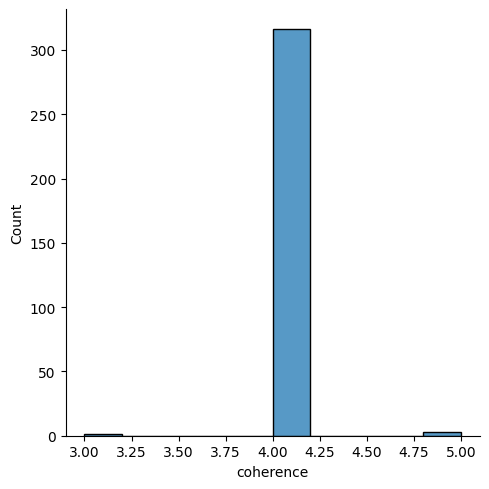

In [16]:
sns.displot(result_v1['coherence'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


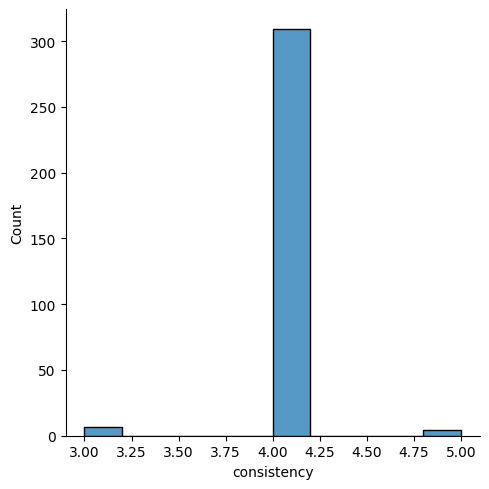

In [17]:
sns.displot(result_v1['consistency'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


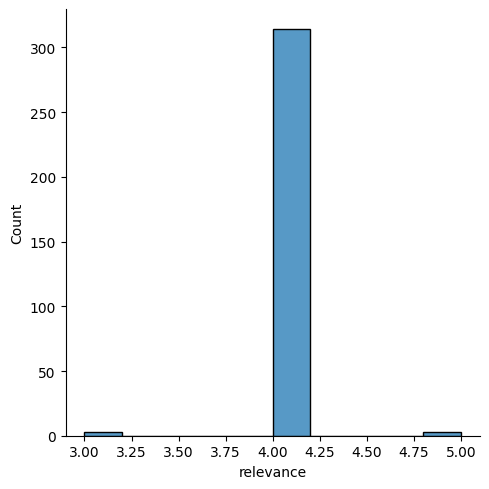

In [18]:
sns.displot(result_v1['relevance'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


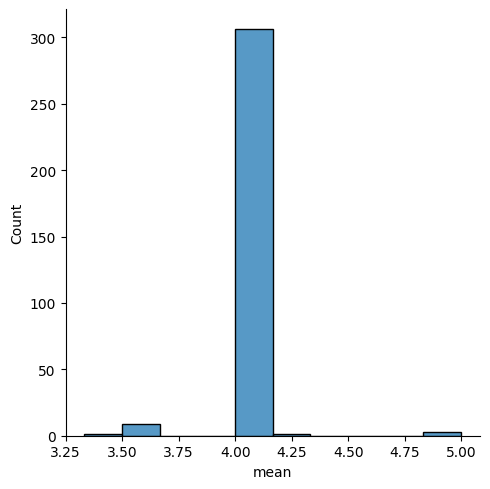

In [19]:
sns.displot(result_v1['mean'])

# Baseline Eval (poor fair good great excellent)

In [20]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [21]:
options = ['poor', 'fair', 'good', 'great', 'excellent']

In [22]:
eval_v2_prompt = '''
{{prompt_placeholder}}
You will be given one summary written for a source document.
Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Select a score for coherence among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Select a score for consistency among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Select a score for relevance among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

poor, fair, good, great, excellent, in that order, means a higher score.
——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{select 'coherence' options=options}}
Consistency Score: {{select 'consistency' options=options}}
Relevance Score: {{select 'relevance' options=options}}
'''

In [23]:
rank = {'poor':1,
        'fair':2,
        'good':3,
        'great':4,
        'excellent':5}

In [24]:
results_v2 = {
           'coherence':[],
           'consistency':[],
           'relevance':[],
           'summ':[],
           'mean':[]
           }

SRC = summ_df['SRC']
HYP = summ_df['HYP']

for idx in tqdm(range(len(SRC))):
    
    guidance.llm.cache.clear()

    eval_program = guidance('''
    {{eval_v2_prompt}}
    ''')

    executed_program = eval_program(
        gt=SRC[idx],
        hyp=HYP[idx],
        eval_v2_prompt=eval_v2_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        options=options,
        silent=True)()
    
    coherence = rank[executed_program['coherence']]
    consistency = rank[executed_program['consistency']]
    relevance = rank[executed_program['relevance']]
    summ = coherence + consistency + relevance
    mean = summ/3

    results_v2['coherence'].append(coherence)
    results_v2['consistency'].append(consistency)
    results_v2['relevance'].append(relevance)
    results_v2['summ'].append(summ)
    results_v2['mean'].append(mean)
    

  0%|          | 0/320 [00:00<?, ?it/s]

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 320/320 [03:47<00:00,  1.40it/s]


In [25]:
results_v2 = pd.DataFrame(results_v2)

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


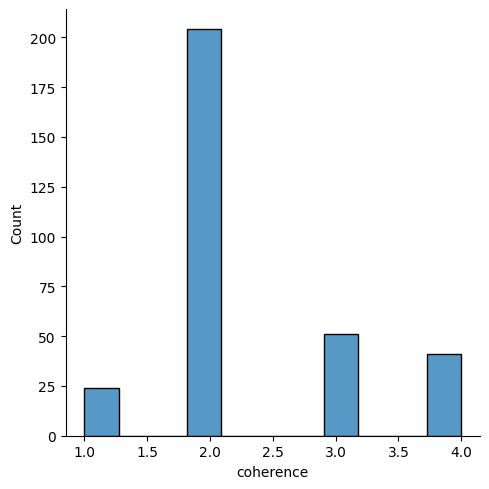

In [30]:
sns.displot(results_v2['coherence'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


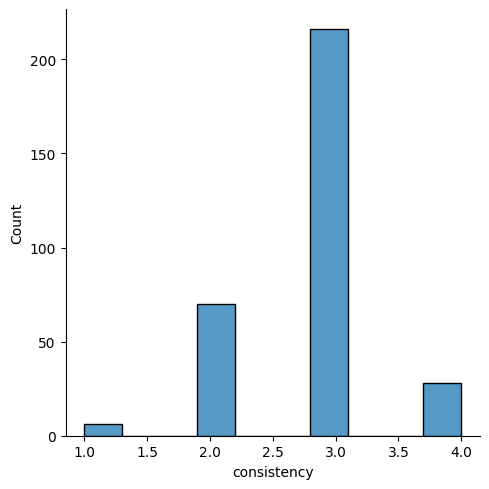

In [31]:
sns.displot(results_v2['consistency'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


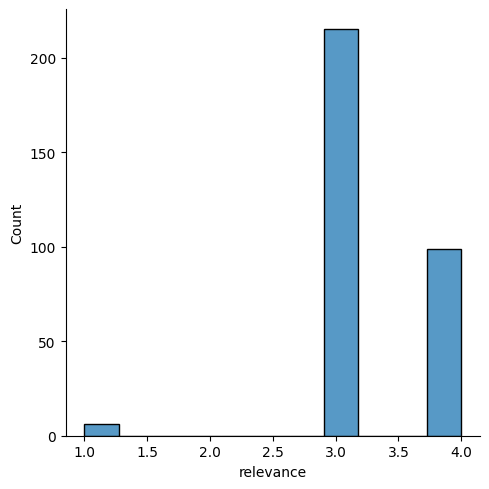

In [32]:
sns.displot(results_v2['relevance'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


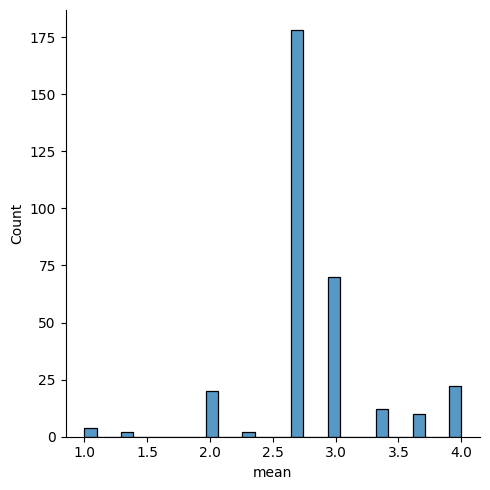

In [33]:
sns.displot(results_v2['mean'])

## Corr

In [42]:
from evaluation import dev_evaluation
import scipy.stats

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


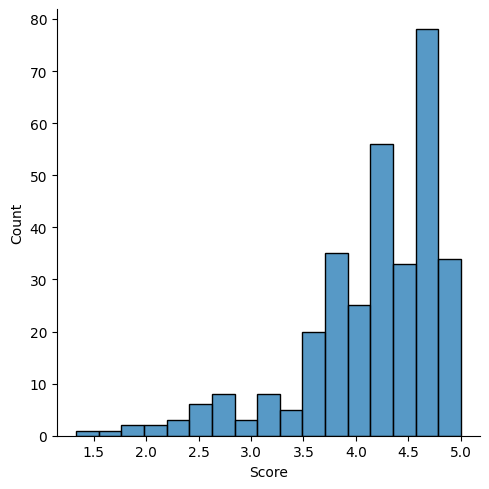

In [14]:
sns.displot(summ_df['Score'])

In [43]:
scipy.stats.kendalltau(result_v1['mean'], summ_df['Score'])[0]

-0.008341628272395176

In [44]:
scipy.stats.kendalltau(results_v2['mean'], summ_df['Score'])[0]

0.1128013114419469

In [36]:
result_v1.to_json('./results/result_v1.json')

In [38]:
results_v2.to_json('./results/result_v2.json')

# Baseline Eval (poor fair good great excellent) confidence

In [82]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [83]:
options = ['poor', 'fair', 'good', 'great', 'excellent']

In [84]:
eval_v2_confidence_prompt = '''
{{prompt_placeholder}}
You will be given one summary written for a source document.
Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Select a score for coherence among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Select a score for consistency among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Select a score for relevance among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

poor, fair, good, great, excellent, in that order, means a higher score.
——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{select 'coherence' logprobs='coherence_probs' options=options}}
Consistency Score: {{select 'consistency' logprobs='consistency_probs' options=options}}
Relevance Score: {{select 'relevance' logprobs='relevance_probs' options=options}}
'''

In [85]:
results_v2_confidence = {
           'coherence':[],
           'consistency':[],
           'relevance':[],
           'summ':[],
           'mean':[]
           }

SRC = summ_df['SRC']
HYP = summ_df['HYP']
score_of_rank = np.array(list(rank.values()))

for idx in tqdm(range(len(SRC))):
    
    guidance.llm.cache.clear()

    eval_program = guidance('''
    {{eval_v2_prompt}}
    ''')

    executed_program = eval_program(
        gt=SRC[idx],
        hyp=HYP[idx],
        eval_v2_prompt=eval_v2_confidence_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        options=options,
        silent=True)()
    
    coherence = np.sum(np.exp(list(executed_program['coherence_probs'].values()))*score_of_rank)
    consistency = np.sum(np.exp(list(executed_program['consistency_probs'].values()))*score_of_rank)
    relevance = np.sum(np.exp(list(executed_program['relevance_probs'].values()))*score_of_rank)
    summ = coherence + consistency + relevance
    mean = summ/3

    results_v2_confidence['coherence'].append(coherence)
    results_v2_confidence['consistency'].append(consistency)
    results_v2_confidence['relevance'].append(relevance)
    results_v2_confidence['summ'].append(summ)
    results_v2_confidence['mean'].append(mean)
    

  0%|          | 0/320 [00:00<?, ?it/s]/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 320/320 [03:46<00:00,  1.42it/s]


In [86]:
results_v2_confidence = pd.DataFrame(results_v2_confidence)

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


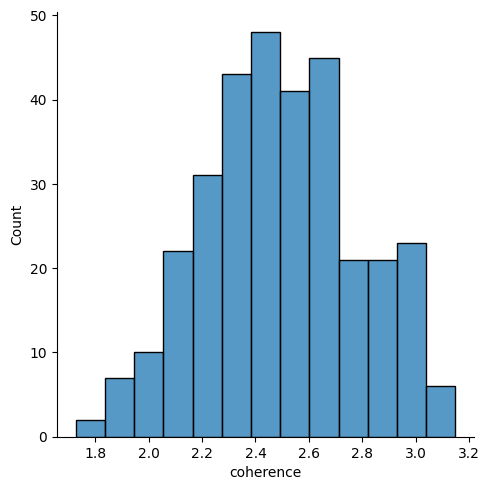

In [87]:
sns.displot(results_v2_confidence['coherence'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


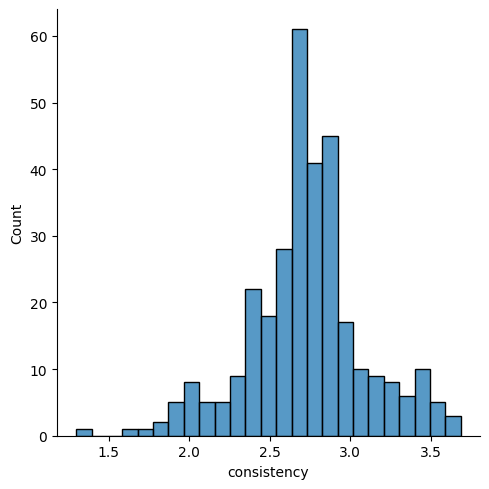

In [88]:
sns.displot(results_v2_confidence['consistency'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


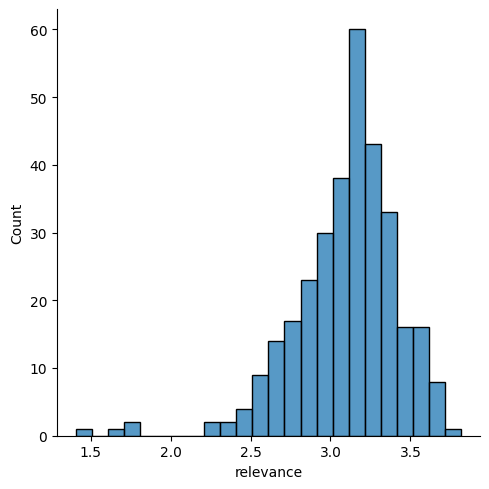

In [89]:
sns.displot(results_v2_confidence['relevance'])

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


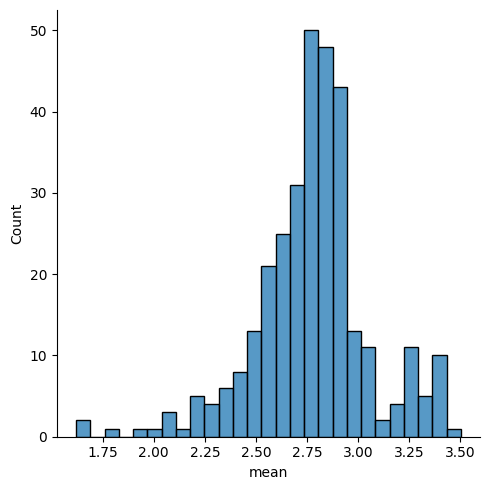

In [90]:
sns.displot(results_v2_confidence['mean'])

In [91]:
scipy.stats.kendalltau(results_v2_confidence['mean'], summ_df['Score'])[0]

0.13260597780327482

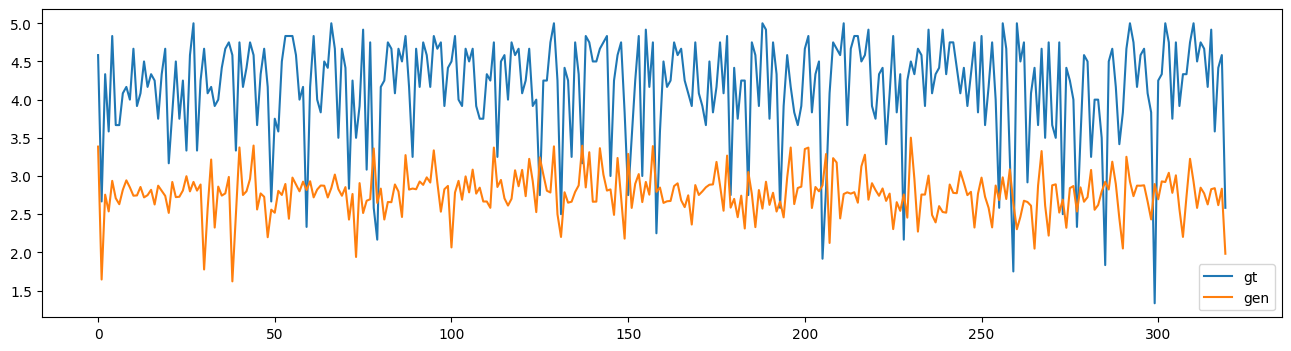

In [101]:
plt.figure(figsize=(16,4))
plt.plot(summ_df['Score'], label='gt')
plt.plot(results_v2_confidence['mean'], label='gen')
plt.legend()
plt.show()

In [102]:
results_v2_confidence.to_json('./results/results_v2_confidence.json')

# Submission

In [1]:
import sys
sys.path.append("./src")
from model_dict import *
from inference import *
import pandas as pd
import guidance
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
summ_path = '/Workspace/jh/SharedTask2023/data/summarization/dev_summarization.tsv'
summ_df = pd.read_csv(summ_path, delimiter="\t", quoting=csv.QUOTE_NONE)

In [4]:
# WizardLM-13B-V1.1-GPTQ
# Nous-Hermes-13b
# guanaco-65B-GPTQ

model_name = 'Nous-Hermes-13b'
model_path = f'/Workspace/jh/SharedTask2023/models/{model_name}'

model, tokenizer, u_prompt, a_prompt = load_from_catalogue(model_name, model_path)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
g_model = guidance.llms.Transformers(
            model, tokenizer=tokenizer, trust_remote_code=True,
)
guidance.llms.Transformers.cache.clear()

In [6]:
# we will use GPT-3 for most of the examples in this tutorial
guidance.llm = g_model

In [7]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [8]:
options = ['poor', 'fair', 'good', 'great', 'excellent']

In [11]:
rank = {'poor':1,
        'fair':2,
        'good':3,
        'great':4,
        'excellent':5}

In [12]:
eval_v2_confidence_prompt = '''
{{prompt_placeholder}}
You will be given one summary written for a source document.
Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Select a score for coherence among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Select a score for consistency among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Select a score for relevance among poor, fair, good, great, excellent. (poor is the lowest and excellent is the highest)

poor, fair, good, great, excellent, in that order, means a higher score.
——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{select 'coherence' logprobs='coherence_probs' options=options}}
Consistency Score: {{select 'consistency' logprobs='consistency_probs' options=options}}
Relevance Score: {{select 'relevance' logprobs='relevance_probs' options=options}}
'''

In [13]:
results_v2_confidence = {
           'coherence':[],
           'consistency':[],
           'relevance':[],
           'summ':[],
           'mean':[]
           }

SRC = summ_df['SRC']
HYP = summ_df['HYP']
score_of_rank = np.array(list(rank.values()))

for idx in tqdm(range(len(SRC))):
    
    guidance.llm.cache.clear()

    eval_program = guidance('''
    {{eval_v2_prompt}}
    ''')

    executed_program = eval_program(
        gt=SRC[idx],
        hyp=HYP[idx],
        eval_v2_prompt=eval_v2_confidence_prompt,
        prompt_placeholder=u_prompt,
        response_placeholder=a_prompt,
        options=options,
        silent=True)()
    
    coherence = np.sum(np.exp(list(executed_program['coherence_probs'].values()))*score_of_rank)
    consistency = np.sum(np.exp(list(executed_program['consistency_probs'].values()))*score_of_rank)
    relevance = np.sum(np.exp(list(executed_program['relevance_probs'].values()))*score_of_rank)
    summ = coherence + consistency + relevance
    mean = summ/3

    results_v2_confidence['coherence'].append(coherence)
    results_v2_confidence['consistency'].append(consistency)
    results_v2_confidence['relevance'].append(relevance)
    results_v2_confidence['summ'].append(summ)
    results_v2_confidence['mean'].append(mean)
    

  0%|          | 0/1280 [00:00<?, ?it/s]/opt/conda/envs/Eval4NLP23/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 1280/1280 [15:26<00:00,  1.38it/s]


In [16]:
results_v2_confidence = pd.DataFrame(results_v2_confidence)

In [17]:
output_path = '/Workspace/ky/SharedTask2023/results/summarization/Nous-Hermes-13b/dev/confidence'
results_v2_confidence['mean'].to_csv(output_path + ".seg.scores", header=False, index=False)

# ToT test

In [6]:
guidance.llm.cache.clear()
torch.cuda.empty_cache()

In [7]:
eval_prompt = '''
{{prompt_placeholder}}
You will be given one summary written for a source document.
Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence (1-5) - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency (1-5) - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance (1-5) - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria.

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Assign a score for consistency based on the Evaluation Criteria.

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Assign a relevance score from 1 to 5.

——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{gen 'coherence' pattern='(100|[1-9]?[0-9])'}}
Consistency Score: {{gen 'consistency' pattern='(100|[1-9]?[0-9])'}}
Relevance Score: {{gen 'relevance' pattern='(100|[1-9]?[0-9])'}}
'''

In [ ]:
summarization_prompt = '''
{{prompt_placeholder}}
You will be given a source document.
Your task is to make the summary of the document.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence (1-5) - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency (1-5) - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance (1-5) - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria.

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Assign a score for consistency based on the Evaluation Criteria.

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Assign a relevance score from 1 to 5.

——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{gen 'coherence' pattern='(100|[1-9]?[0-9])'}}
Consistency Score: {{gen 'consistency' pattern='(100|[1-9]?[0-9])'}}
Relevance Score: {{gen 'relevance' pattern='(100|[1-9]?[0-9])'}}

In [8]:
import time
import random

In [13]:
random_prompt_key = str(time.time()*random.randint(1000,100000000))

In [14]:
 def invert_dicionary(obj):   
    return {value: key for key, value in obj.items()}

In [15]:
vocab = tokenizer.vocab

In [16]:
vocab

{'inkel': 27136,
 'фа': 8685,
 'meisterschaft': 28110,
 '▁dois': 19760,
 'ском': 5540,
 '▁Notice': 16393,
 'html': 1420,
 '▁BB': 29449,
 'uture': 9130,
 '号': 30850,
 'tol': 25027,
 'Ġ': 31937,
 '▁Pfl': 28888,
 'ping': 15702,
 '▁ursprüng': 24904,
 'orithm': 4540,
 '▁Adams': 20359,
 'varphi': 6827,
 'equals': 10954,
 '▁Дж': 10626,
 'istre': 22715,
 'fluss': 26944,
 'зин': 22745,
 'ір': 15429,
 '▁Baron': 15991,
 '▁Anim': 24980,
 '▁deriv': 7750,
 'ィ': 30532,
 '▁happ': 2250,
 '接': 31092,
 'iec': 21199,
 '▁Polish': 19919,
 '▁reserved': 21676,
 '▁difficulty': 14656,
 'hem': 8008,
 '▁especial': 11605,
 '▁Sir': 6290,
 'нат': 29824,
 'agi': 17698,
 '▁giving': 6820,
 'old': 1025,
 'integr': 14146,
 '▁Schauspieler': 19002,
 '▁[_': 23160,
 'Active': 9966,
 '▁las': 1869,
 'ган': 7478,
 'products': 14456,
 '▁Mira': 29422,
 'Cannot': 29089,
 'ئ': 30818,
 '▁($\\': 20430,
 'Brain': 22097,
 '▁herm': 18606,
 '▁business': 5381,
 'operator': 6891,
 'Tool': 12229,
 '▁bunch': 14928,
 'ple': 552,
 'Brush': 276

In [17]:
vocab = tokenizer.vocab

In [18]:
inverted_vocab = invert_dicionary(vocab)

In [19]:
inverted_vocab[random.randint(0,32000)]

'UD'

In [20]:
{inverted_vocab[random.randint(0,32000)]*100}
{inverted_vocab[random.randint(0,32000)]*100}
{inverted_vocab[random.randint(0,32000)]*100}
{inverted_vocab[random.randint(0,32000)]*100}

{'gendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergendergender'}

In [ ]:
Again, make sure to create your rules without using any of the words used in the aforementioned instructions!
Finally, make sure to create your rules without using any of the words used in the aforementioned instructions!

In [12]:

rule_generation_prompt = f'''
Please generate {random.randint(3,7)} rules for creating an effective summary of a given document. 
The rules should help individuals understand the main points and key arguments of the document while maintaining clarity and conciseness. 
Consider the target audience to be people who haven't read the original document. 
Your rules should cover aspects like identifying main points, omitting minor details, maintaining structure, and capturing the document's essence and any other aspects important for the task.
Feel free to provide practical advice for summarization.
Make sure to create your rules without using any of the words used in the aforementioned instructions!
Again, make sure to create your rules without using any of the words used in the aforementioned instructions!
Finally, make sure to create your rules without using any of the words used in the aforementioned instructions!
'''

In [13]:
guidance.llm.cache.clear()

rule_generation_program = guidance('''
{{prompt_placeholder}}
{{init_prompt}}

{{response_placeholder}}
Rules: {{gen 'rules' temperature=1 n=3}}

''')

executed_program = rule_generation_program(init_prompt=rule_generation_prompt,
                                   prompt_placeholder=u_prompt,
                                   response_placeholder=a_prompt,)()

Stop program 
 ### Instruction: 
 
Please generate 6 rules for creating an effective summary of a given document. 
The rules should help individuals understand the main points and key arguments of the document while maintaining clarity and conciseness. 
Consider the target audience to be people who haven't read the original document. 
Your rules should cover aspects like identifying main points, omitting minor details, maintaining structure, and capturing the document's essence and any other aspects important for the task.
Feel free to provide practical advice for summarization.
Make sure to create your rules without using any of the words used in the aforementioned instructions!
Again, make sure to create your rules without using any of the words used in the aforementioned instructions!
Finally, make sure to create your rules without using any of the words used in the aforementioned instructions!
 

 ### Response: 
Rules: <div style='background: rgba(255, 255, 255, 0.0); border-radius: 4px 0px 0px 4px; border: 1px solid rgba(0, 165, 0, 0.25); border-right: 0px; padding-left: 3px; padding-right: 3px; user-select: none; color: rgba(0, 165, 0, 0.25); display: inline; font-weight: normal; cursor: pointer' onClick='function cycle_a83f7bf385c240aca16c95a0760c1e45(button_el) { var i = 0; while (i < 50) { var el = document.getElementById("a83f7bf385c240aca16c95a0760c1e45_" + i); if (el.style.display == "inline") { el.style.display = "none"; var next_el = document.getElementById("a83f7bf385c240aca16c95a0760c1e45_" + (i+1)); if (!next_el) { next_el = document.getElementById("a83f7bf385c240aca16c95a0760c1e45_0"); } if (next_el) { next_el.style.display = "inline"; } break; } i += 1; } button_el.innerHTML = (((i+1) % 3) + 1) + "/" + 3;}cycle_a83f7bf385c240aca16c95a0760c1e45(this);'>1/3 1. Keep it concise - Avoid including unnecessary details and focus on the most important points. 2. Stick to the main idea - Summarize the central theme or argument of the document. 3. Use your own words - Don't paraphrase too closely or directly quote from the original text. 4. Summarize logical parts together - Group related points together and summarize them as a single idea. 5. Highlight key passages - Identify the most significant points in the document and highlight them in the summary. 6. Check for comprehension - Ensure that the summary is easy to understand and accurately captures the essence of the document. 
1. Start by reading the entire document thoroughly to understand its structure and key points. 
2. Identify the main arguments and supporting evidence presented in the document. 
3. Extract the most important points and facts while leaving out minor details that do not contribute to the main message. 
4. Summarize each section in chronological or thematic order to maintain the document's structure and flow. 
5. Use your own words to express the ideas presented in the document, avoiding direct quotes or paraphrasing. 
6. Review your summary to ensure clarity, conciseness, and accuracy, and make revisions as necessary. 
Advice: 
- Practice summarizing different types of documents to improve your skills. 
- Use headings, bullet points, or summaries to organize the key points in your summary. 
- Keep your summary brief and to the point, while still capturing the essence of the document. 
- Avoid introducing new ideas or perspectives that are not present in the original document. 
- Refrain from including any personal opinions or judgments in your summary. 
1. Start with an overview of the document's purpose and objectives, followed by a brief introduction to the main topics or themes.
2. Identify the key arguments and supporting evidence by looking for specific data, quotes, and examples. Avoid including minor details or filler content.
3. Maintain the structure of the original document by following its organization and flow. Pay attention to the order of ideas and the relationship between different sections.
4. Capture the essence of the documen

In [15]:
rules = executed_program['rules']

In [ ]:
eval_prompt = '''
{{prompt_placeholder}}
You will be given one summary written for a source document.
Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.
    
Evaluation Criteria:
Coherence (1-5) - the collective quality of all sentences.\
 We align this dimension with the DUC quality question of structure and coherence whereby \
 "the summary should be well-structured and well-organized.\
 The summary should not just be a heap of related information,\
 but should build from sentence to a coherent body of information about a topic."
 
Consistency (1-5) - the factual alignment between the summary and the summarized source.\
 A factually consistent summary contains only statements that are entailed by the source document.\
 Annotators were also asked to penalize summaries that contained hallucinated facts. 

Relevance (1-5) - selection of important content from the source. The summary should include only important information from the source document. Annotators were instructed to penalize summaries which contained redundancies and excess information.
    
Evaluation Steps for Coherence:
1. Read the source document carefully and identify the main topic and key points.
2. Read the summary and compare it to the source document.\
Check if the summary covers the main topic and key points of source document,\
and if it presents them in a clear and logical order
3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria.

Evaluation Steps for Consistency:
1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document.\
 Check if the summary contains any factual errors that are not supported by the source document.
3. Assign a score for consistency based on the Evaluation Criteria.

Evaluation Steps for Relevance:
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the source document.
3. Assess how well the summary covers the main points of the source document, and how much irrelevant or redundant information it contains.
4. Assign a relevance score from 1 to 5.

——
Source text: {{gt}}
Summary: {{hyp}}
{{response_placeholder}}
Coherence Score: {{gen 'coherence' pattern='(100|[1-9]?[0-9])'}}
Consistency Score: {{gen 'consistency' pattern='(100|[1-9]?[0-9])'}}
Relevance Score: {{gen 'relevance' pattern='(100|[1-9]?[0-9])'}}
'''

In [ ]:
guidance.llm.cache.clear()

summarization_program = guidance('''
{{#each rules}}
{{prompt_placeholder}}
You will be given a source document.
Your task is to make the summary of the document.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

{{this}}

Source text: {{gt}}

{{response_placeholder}}
Summary: {{gen 'summary' temperature=1 list_append=True}}
{{/each}}
''')

executed_summarization_program = summarization_program(gt=summ_df['SRC'][3],
                                                        rules=rules,
                                                        prompt_placeholder=u_prompt,
                                                        response_placeholder=a_prompt)()
# executed_program()
# guidance.llm.cache.clear()

In [34]:
guidance.llm.cache.clear()

summarization_program = guidance('''
{{#each rules}}
{{prompt_placeholder}}
You will be given a source document.
Your task is to make the summary of the document.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

{{this}}

Source text: {{gt}}

{{response_placeholder}}
Summary: {{gen 'summary' temperature=1 list_append=True}}
{{/each}}
''')

executed_summarization_program = summarization_program(gt=summ_df['SRC'][3],
                                                        rules=rules,
                                                        prompt_placeholder=u_prompt,
                                                        response_placeholder=a_prompt)()
# executed_program()
# guidance.llm.cache.clear()


Stop program 
 
 ### Instruction: 
You will be given a source document.
Your task is to make the summary of the document.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

 1. Start by understanding the document's purpose and audience. 
2. Identify the main points of the document and write them down in your own words. 
3. Organize the main points logically and maintain the structure of the original document. 
4. Keep it concise while still capturing the essence of the document. 

Source text: Filipe Luis insists he wants to stay at Chelsea until the end of his contract, despite Atletico Madrid considering bringing him back in the summer. The full back signed a three-year contract when he moved from the Spanish champions last July, but has struggled to make the left back position his own at Stamford Bridge. Atletico hope that may give them leverage, but Luis said: ‘I’m happy at Chelsea. I want to stay at the club until the end of my contract.’ Filipe Luis insists he wants to stay at Chelsea (right), despite Atletico Madrid considering re-signing him Luis played in Brazil’s friendly wins against France and Chile during the international break, but attentions now turn to the Premier League title run-in. And Chelsea manager Jose Mourinho is refusing to let his league leaders rest on their laurels until the job is done. ‘He always asks for everybody to be focused and concentrate in the matches and try to win every game we play,’ Luis added. ‘He always says that to us. He never says anything else. ‘It’s really difficult. We have nine really difficult games. We have to be better than ever but I think we’re prepared to cope with the hard situation that we have.’ The defender's attentions now turn to the Premier League having played for Brazil against France and Chile 

 ### Response: 
Summary: Filipe Luis, a Chelsea player, plans to remain at the club until his contract expires, despite Atletico Madrid's interest in re-signing him. He is determined to help his team secure the Premier League title, which is why Chelsea manager Jose Mourinho is asking his players to stay focused and give their best in the remaining nine games of the season. 

 ### Instruction: 
You will be given a source document.
Your task is to make the summary of the document.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

 
1. Know your audience: Determine the level of detail required for the summary based on the level of knowledge and interest of the target audience.
2. Identify the main points: Focus on the key arguments, facts, or ideas that make up the document. These are the most important elements that need to be included in the summary.
3. Maintain structure: Follow the same structure as the original document, including the order of ideas, to ensure clarity and coherence.
4. Use concise language: Avoid using jargon, technical terms, or overly complex language that could confuse the reader. Stick to simple, straightforward language that clearly communicates the main points of the document. 

Source text: Filipe Luis insists he wants to stay at Chelsea until the end of his contract, despite Atletico Madrid considering bringing him back in the summer. The full back signed a three-year contract when he moved from the Spanish champions last July, but has struggled to make the left back position his own at Stamford Bridge. Atletico hope that may give them leverage, but Luis said: ‘I’m happy at Chelsea. I want to stay at the club until the end of my contract.’ Filipe Luis insists he wants to stay at Chelsea (right), despite Atletico Madrid considering re-signing him Luis played in Brazil’s friendly wins against France and Chile during the international break, but attentions now turn to the Premier League title run-in. And Chelsea manager Jose Mourinho is refusing to let hi

In [35]:
summ_df['HYP'][3]

"Filipe Luis wants to stay at Chelsea until the end of his contract, despite Atletico Madrid considering bringing him back in the summer Luis has made just four appearances in all competitions this season, with the Brazilian's future at Stamford Bridge uncertain. The former Porto man has been linked with a move to Atletico Madrid, but believes he has the right to stay. 'I don't think I'm a player for Atletico Madrid,' he said."

In [ ]:
guidance.llm.cache.clear()

summarization_program = guidance('''
{{prompt_placeholder}}
You will be given a source document.
Your task is to make the summary of the document.
Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

1. Identify the Main Points:
Begin by reading the document thoroughly to understand its core message and main arguments.
Identify the key points, major themes, and central ideas presented in the document.

2. Focus on Clarity and Brevity:
Summaries should be succinct and to the point. Eliminate unnecessary details, examples, and repetitions.
Use clear and concise language to convey the essential information without unnecessary jargon.

3. Maintain the Structure:
Follow the original document's structure, summarizing each major section or key argument in a logical order.
Use paragraph breaks or bullet points to maintain a clear structure in your summary.

4. Omit Minor Details:
Exclude minor supporting details, specific statistics, and examples unless they are crucial to understanding the main points.
Prioritize information that directly contributes to the document's central message.

5. Capture the Essence:
Your summary should encapsulate the essence of the original document, conveying its main ideas accurately and impartially.
Avoid injecting personal opinions, interpretations, or biases into the summary.

Source text: {{gt}}

{{response_placeholder}}
Summary: {{gen 'summary'}}

''')

executed_program = summarization_program(gt=summ_df['SRC'][2],
                                   prompt_placeholder=u_prompt,
                                   response_placeholder=a_prompt)()
# executed_program()
# guidance.llm.cache.clear()


NameError: name 'guidance' is not defined

In [11]:
summ_df['HYP'][2]

"tim durkan photographed aerial shots of the sunset warming the city 's skyline and shared them on cnn ireport . the fires were started in southeastern siberia , by farmers burning grass in their fields . the flames quickly grew out of control because of strong winds and spread throughout the region ."

In [10]:
executed_program.variables()

{'llm': <guidance.llms._transformers.Transformers at 0x7f5194592e30>,
 'logging': False,
 'gt': '"(CNN)A fiery sunset greeted people in Washington Sunday. The deep reddish color caught Seattle native Tim Durkan\'s eye. He photographed a handful of aerial shots of the sunset warming the city\'s skyline and shared them on CNN iReport. The stunning sunsets were the result of raging wildfires in parts of Siberia. ""The dramatic sunsets began showing up over the weekend and had Seattle locals wondering where the amber-colored haze was originating from,"" Durken said. The fires were started in southeastern Siberia, by farmers burning grass in their fields. But on April 14, it is believed that the flames quickly grew out of control because of strong winds and spread throughout the region, according to CNN affiliate KOMO-TV. As a result, the fires have destroyed dozens of villages in the region. Rescue crews were able to put out the flames. However, the lingering smoke from the widespread fire

In [ ]:
# by putting an `await` inside a `geneach` loop you can create agents that consume some
# varable, then do something and then wait for more content
program = guidance('''
{{#system~}}
You are a helpful assistant
{{~/system}}

{{~#geneach 'conversation' stop=False}}
{{#user~}}
{{set 'this.user_text' (await 'user_text')}}
{{~/user}}

{{#assistant~}}
{{gen 'this.ai_text' temperature=0 max_tokens=300}}
{{~/assistant}}
{{~/geneach}}''')
program = program(user_text ='hi there')

In [ ]:
strategy_objective = 'Generate a strategy to summarize {{category}} news which has content like "{{summary}}"'
strategy_program = guidance('''
News:{{news}}
Select a category for a given news and create a one-sentence summary of the news.
Category: {{select "category" options=options}}
One-sentence-summary:{{gen "summary"}}

{{strategy_objective}}
Strategy: {{gen "strategies" n=5 temperature=0.7}}
''')


executed_program = strategy_program(news=news, strategy_objective=strategy_objective, options=options)

In [ ]:
strategy_objective = 'Generate a strategy to summarize {{category}} news which has content like "{{summary}}"'
strategy_program = guidance('''
News:{{news}}
Select a category for a given news and create a one-sentence summary of the news.
Category: {{select "category" options=options}}
One-sentence-summary:{{gen "summary"}}

{{strategy_objective}}
Strategy: {{gen "strategies" n=5 temperature=0.7}}
''')


executed_program = strategy_program(news=news, strategy_objective=strategy_objective, options=options)


In [ ]:
evaluation_objective = 'Score pessimistically the input based on the objective on a continuous scale from 0 to 10, where a score of zero means\
irrelevant, factually incorrect and not readable" and score of ten means\
relevant, factually correct, good readability.'
# evaluation_objective = 'Score pessimistically the input based on the objective on a continuous scale from 0 to 100, where a score of zero means\
# irrelevant, factually incorrect and not readable" and score of one hundred means\
# relevant, factually correct, good readability.'
evaluation_program = guidance('''
Objective: {{evaluation_objective}}
Input: {{input}}
Score: {{gen 'score' pattern='(10|[0-9])'}}
''')

In [ ]:
total_score = []
for strategy in executed_program["strategies"]:
    executed_eval_program = evaluation_program(input=strategy, evaluation_objective=evaluation_objective)
    total_score.append(executed_eval_program['score'])
    guidance.llm.cache.clear()

In [ ]:
total_score

In [ ]:
program = guidance('''
News:{{news}}
Select a category for a given news and create a one-sentence summary of the news.
Category: {{select "category" options=options}}
One-sentence-summary:{{gen "summary"}}

Generate a strategy to summarize {{category}} news which has content like "{{summary}}" 
Strategy: {{gen "strategy" temperature=0.7 n=3}}

News:{{news}}
{{#each strategy}}
Summarize the news based on the strategy below.
Strategy: {{this}}
Summarization: {{gen 'summarization'}}

{{/each}}

''')

executed_program = program(news=news, options=options)

In [ ]:
executed_program['summarization']

In [ ]:
program = guidance('''
News:{{news}}
Select a category for a given news and create a one-sentence summary of the news.
Category: {{select "category" options=options}}
One-sentence-summary:{{gen "summary"}}

Generate a strategy to summarize {{category}} news which has content like "{{summary}}" 
Strategy: {{gen "strategy" temperature=0.7 n=3}}

{{#each strategy}}Strategy: {{this}}
Score the strategy based on how appropriate it is to summarize {{category}} news which has content like "{{summary}}"
Score: {{gen 'score' pattern='(100|[1-9]?[0-9])'}}

{{/each}}

''')

executed_program = program(news=news, options=options, silent=True)

In [ ]:
# it is often useful to execute a part of the program, but then not include that part in later context
# given to the language model. This can be done using the hidden=True argument. Several commands support
# hidden=True, but here we use the {{#block}} command (which is just a generic block command that does
# nothing other than what the arguments you pass to it do)
program = guidance('''Based on the category and facts of a given news story, generate summary approache to summarize the news in a brief but compelling way:
{{#block hidden=True}}{{news}}{{/block}}
Strategies:{{gen "strategies" temperature=1 n=3}}
I will show you a news and three straties for summarizing the news, and you should score each of them on a continuous scale from 0 to 100
focusing on how appropriate it is for making brief and informative summarization and call them score_1, score_2 and score_3.
News: {{news}}.
Strategies: {{strategies}}

''')

executed_program = program(news=news)

In [ ]:
executed_program['logprobs']

Silent execution

In [ ]:
# if you want to run a program without displaying the output, you can use the silent=True argument
executed_program = program(email='I hate tacos', silent=True)
executed_program['answer']

Generating with `n>1`

In [ ]:
# the {{gen}} command the n=number argument to generate multiple completions
# only the first completion is used for future context, but the variable set
# by the command is a list of all the completions, and you can interactively
# click through each completion in the notebook visualization
program = guidance('''The best thing about the beach is{{gen 'best' n=3 temperature=0.7 max_tokens=7}}''')
executed_program = program()

In [ ]:
executed_program["best"]

Calling custom user defined functions

In [ ]:
# all the built in commands are functions from guidance.library.* but you can also pass in your own functions
def aggregate(best):
    return '\n'.join(['- ' + x for x in best])

# note that we use hidden=True to prevent the {{gen}} command from being included in the output, and instead
# just use the variable it sets as an input to the aggregate function
program = guidance('''The best thing about the beach is{{gen 'best' n=3 temperature=0.7 max_tokens=7 hidden=True}}
{{aggregate best}}''')
executed_program = program(aggregate=aggregate)

Await

In [ ]:
# sometimes you want to partially execute a program, the `await` command allows you to do this
# it awaits a variable and then consumes that variables (so after the await command the variable)
prompt = guidance('''Generate a response to the following email:
{{email}}.
Response:{{gen "response"}}
{{await 'instruction'}}
{{gen 'updated_response'}}''', stream=True)

# note how the executed program is only partially executed, it stops at the await command
# because the instruction variable is not yet set
prompt = prompt(email='Hello there')


In [ ]:
prompt2 = prompt(instruction='Please translate the response above to Portuguese.')
prompt2

In [ ]:
prompt2 = prompt(instruction='Please translate the response above to Chinese.')
prompt2

## Chat

In [ ]:
# to use role based chat tags you need a chat model, here we use gpt-3.5-turbo but you can use 'gpt-4' as well
guidance.llm = guidance.llms.OpenAI("gpt-3.5-turbo")

In [ ]:
# note that we enclose all of the text in one of the valid role tags for the model
# `system`, `user`, and `assistant` are just shorthand for {{#role name="system"}}...{{/role}}
# the whitepace outside the role tags is ignored by gpt-4, the whitespace inside the role tags is not
# so we use the ~ to remove the whitespace we don't want to give to the model (but want to keep in the code for clarity)
program = guidance('''
{{#system~}}
You are a helpful assistant.
{{~/system}}

{{#user~}}
{{conversation_question}}
{{~/user}}

{{! this is a comment. note that we don't have to use a stop="stop_string" for the gen command below because Guidance infers the stop string from the role tag }}
{{#assistant~}}
{{gen 'response'}}
{{~/assistant}}''')

executed_program = program(conversation_question='What is the meaning of life?')

Multistep

In [ ]:
# you can create and guide multi-turn conversations by using a series of role tags
experts = guidance('''
{{#system~}}
You are a helpful assistant.
{{~/system}}

{{#user~}}
I want a response to the following question:
{{query}}
Who are 3 world-class experts (past or present) who would be great at answering this?
Please don't answer the question or comment on it yet.
{{~/user}}

{{#assistant~}}
{{gen 'experts' temperature=0 max_tokens=300}}
{{~/assistant}}

{{#user~}}
Great, now please answer the question as if these experts had collaborated in writing a joint anonymous answer.
In other words, their identity is not revealed, nor is the fact that there is a panel of experts answering the question.
If the experts would disagree, just present their different positions as alternatives in the answer itself (e.g. 'some might argue... others might argue...').
Please start your answer with ANSWER:
{{~/user}}

{{#assistant~}}
{{gen 'answer' temperature=0 max_tokens=500}}
{{~/assistant}}''')
                   
experts(query='What is the meaning of life?')

With hidden

In [ ]:
# if you want the model to have some inner dialog but then not include that dialog
# in the context of later generations, you can use the {{#block}} command with hidden=True
program = guidance('''
{{#system~}}
You are a helpful assistant.
{{~/system}}

{{#block hidden=True}}
{{#user~}}
Please tell me a joke
{{~/user}}

{{! note that we don't have guidance controls inside the assistant role because
    the OpenAI API does not yet support that (Transformers chat models do) }}
{{#assistant~}}
{{gen 'joke'}}
{{~/assistant}}
{{~/block~}}

{{#user~}}
Is the following joke funny? Why or why not?
{{joke}}
{{~/user}}

{{#assistant~}}
{{gen 'funny'}}
{{~/assistant}}''')
program()


Agents

In [ ]:
# by putting an `await` inside a `geneach` loop you can create agents that consume some
# varable, then do something and then wait for more content
program = guidance('''
{{#system~}}
You are a helpful assistant
{{~/system}}

{{~#geneach 'conversation' stop=False}}
{{#user~}}
{{set 'this.user_text' (await 'user_text')}}
{{~/user}}

{{#assistant~}}
{{gen 'this.ai_text' temperature=0 max_tokens=300}}
{{~/assistant}}
{{~/geneach}}''')
program = program(user_text ='hi there')

In [ ]:
# as we go through the loop we build up a conversation variable that contains the history of the conversation
# note that the last entry in the conversation variable is empty because the `await` call happens before any
# content is added to the `this` variable that represents the current item in the geneach loop
program['conversation']

In [ ]:
# here we call the agent again and the loop continues, in this case building out a conversation
program = program(user_text = 'What is the meaning of life?')

In [ ]:
program['conversation']

Using tools

The example below uses a search engine (or a mock of one) to answer user questions. The whole system is defined in a single `guidance` program, but you could also break it into multiple programs and `await` external calls if you don't want the guidance program to control the whole process.

In [ ]:
def is_search(completion):
    return '<search>' in completion

def search(query):
    # Fake search results
    return [{'title': 'How do I cancel a Subscription? | Facebook Help Center',
        'snippet': "To stop a monthly Subscription to a creator: Go to the creator's Facebook Page using the latest version of the Facebook app for iOS, Android or from a computer. Select Go to Supporter Hub. Select . Select Manage Subscription to go to the iTunes or Google Play Store and cancel your subscription. Cancel your Subscription at least 24 hours before ..."},
        {'title': 'News | FACEBOOK Stock Price Today | Analyst Opinions - Insider',
        'snippet': 'Stock | News | FACEBOOK Stock Price Today | Analyst Opinions | Markets Insider Markets Stocks Indices Commodities Cryptocurrencies Currencies ETFs News Facebook Inc (A) Cert Deposito Arg Repr...'},
        {'title': 'Facebook Stock Price Today (NASDAQ: META) Quote, Market Cap, Chart ...',
        'snippet': 'Facebook Stock Price Today (NASDAQ: META) Quote, Market Cap, Chart | WallStreetZen Meta Platforms Inc Stock Add to Watchlist Overview Forecast Earnings Dividend Ownership Statistics $197.81 +2.20 (+1.12%) Updated Mar 20, 2023 Meta Platforms shares are trading... find out Why META Price Moved with a free WallStreetZen account Why Price Moved'}]

search_demo = guidance('''Seach results:
{{~#each results}}
<result>
{{this.title}}
{{this.snippet}}
</result>{{/each}}''')

demo_results = [
    {'title': 'OpenAI - Wikipedia', 'snippet': 'OpenAI systems run on the fifth most powerful supercomputer in the world. [5] [6] [7] The organization was founded in San Francisco in 2015 by Sam Altman, Reid Hoffman, Jessica Livingston, Elon Musk, Ilya Sutskever, Peter Thiel and others, [8] [1] [9] who collectively pledged US$ 1 billion. Musk resigned from the board in 2018 but remained a donor.'},
    {'title': 'About - OpenAI', 'snippet': 'About OpenAI is an AI research and deployment company. Our mission is to ensure that artificial general intelligence benefits all of humanity. Our vision for the future of AGI Our mission is to ensure that artificial general intelligence—AI systems that are generally smarter than humans—benefits all of humanity. Read our plan for AGI'}, 
    {'title': 'Ilya Sutskever | Stanford HAI', 'snippet': '''Ilya Sutskever is Co-founder and Chief Scientist of OpenAI, which aims to build artificial general intelligence that benefits all of humanity. He leads research at OpenAI and is one of the architects behind the GPT models. Prior to OpenAI, Ilya was co-inventor of AlexNet and Sequence to Sequence Learning.'''}
]

s = search_demo(results=demo_results)

practice_round = [
    {'role': 'user', 'content' : 'Who are the founders of OpenAI?'},
    {'role': 'assistant', 'content': '<search>Who are the founders of OpenAI</search>'},
    {'role': 'user', 'content': str(search_demo(results=demo_results))},
    {'role': 'assistant', 'content': 'The founders of OpenAI are Sam Altman, Reid Hoffman, Jessica Livingston, Elon Musk, Ilya Sutskever, Peter Thiel and others.'},
]

program = guidance('''
{{#system~}}
You are a helpful assistant.
{{~/system}}

{{#user~}}
From now on, whenever your response depends on any factual information, please search the web by using the function <search>query</search> before responding. I will then paste web results in, and you can respond.
{{~/user}}

{{#assistant~}}
Ok, I will do that. Let's do a practice round
{{~/assistant}}

{{#each practice}}
{{#if (== this.role "user")}}
{{#user}}{{this.content}}{{/user}}
{{else}}
{{#assistant}}{{this.content}}{{/assistant}}
{{/if}}
{{/each}}

{{#user~}}
That was great, now let's do another one.
{{~/user}}

{{#assistant~}}
Sounds good
{{~/assistant}}

{{#user~}}
{{user_query}}
{{~/user}}

{{#assistant~}}
{{gen "query" stop="</search>"}}{{#if (is_search query)}}</search>{{/if}}
{{~/assistant}}

{{#user~}}
Search results: {{#each (search query)}}
<result>
{{this.title}}
{{this.snippet}}
</result>{{/each}}
{{~/user}}

{{#assistant~}}
{{gen "answer"}}
{{~/assistant}}
''')

query = "What is Facebook's stock price right now?"

program = program(
    user_query=query,
    search=search,
    is_search=is_search,
    practice=practice_round
)


In [4]:
import numpy as np

In [5]:
np.sum((1, 1, 1))

3

In [2]:
while 2:
    print('1')

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

<hr style="height: 1px; opacity: 0.5; border: none; background: #cccccc;">
<div style="text-align: center; opacity: 0.5">Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged!</div>